In [6]:
from typing import Tuple, Optional, Union
import math
import torch as th
import torch
import torch.nn as nn
import torchaudio as ta
from torchaudio.transforms import PSD
import torch.nn.functional as F

from Modules import STFT, MVDR
from model import Unet_model
from data import my_dataset
from matplotlib import pyplot as plt
from loss import MultiResSpecLoss

In [7]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from model import DownSample, UpSample

class Unet_model(nn.Module):
    def __init__(
        self, input_channel=1, out_channel=32, complex_input=True, log_flag=True, subband_flag=False):
        super().__init__()
        self.complex_input = complex_input
        self.log_flag = log_flag
        self.subband_flag = subband_flag
        
        self.down_1 = DownSample(
                input_channel=40,
                out_channel=64, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(64)
            )
        
        self.down_2 = DownSample(
                input_channel=64,
                out_channel=128, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(128)
            )
        
        self.lstm = nn.LSTM(input_size=256, 
                            hidden_size=256, 
                            num_layers=1, 
                            batch_first=True)
        
        
        self.up_1 = UpSample(
            input_channel=128+128, 
            out_channel=64, 
            kernel_size=(6, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(64)
        )    
        

        self.up_2 = UpSample(
            input_channel=64+64, 
            out_channel=32, 
            kernel_size=(4, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(32)
        )   
        
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 128, 1, 1, 0, bias=False),
            nn.GELU(),
            nn.Conv2d(128, 5, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def cac2cws(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c,k,f//k,t)
        x = x.reshape(b,c*k,f//k,t)
        return x
    
    def cws2cac(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c//k,k,f,t)
        x = x.reshape(b,c//k,f*k,t)
        return x
    
    def forward(self, x):
        B, C, F, T = x.shape
        
        if self.complex_input:
            x = torch.concat([x.real, x.imag], dim=1)
        elif self.log_flag:
            x = torch.log(x + 1e-5)
        
        if self.subband_flag:
            x = self.cac2cws(x)
        #print(x.shape)
        x1 = self.down_1(x)
        x2 = self.down_2(x1)        
        _, C_c, F_c, _ = x2.shape
        x = x2.view(B, -1, T).permute(0, 2, 1) # (B, C, F, T) -> (B, C*F, T) -> (B, T, C*F)
        
        x = self.lstm(x)[0] + x
        
        x = x.permute(0, 2, 1).view(B, C_c, F_c, T)
        x = self.up_1(torch.concat([x, x2],dim=1))
        x = self.up_2(torch.concat([x, x1],dim=1))
        x = self.final_conv(x)
        x = self.cws2cac(x)
        #x = x.view(B, -1, T).permute(0, 2, 1)
        #x = self.fc(x)
        
        return x#x.view(B, 1, F, T)

In [8]:
data_train = my_dataset('./beam_data/train')

model_mask = Unet_model(subband_flag=True)
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [9]:
train_target, train_sample, train_noise = data_train[0]

In [10]:
crit = MultiResSpecLoss(factor=100,
            f_complex=100,
            gamma=0.3,
            n_ffts=[1024, window_length])

In [11]:
from tqdm import tqdm
from torchmetrics import ScaleInvariantSignalNoiseRatio

epochs = 1000

optim = torch.optim.AdamW(model_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )

si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
#     mvdr = MVDR(0)
    spec_sample = stft.stft(train_sample[None])
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

    mask = model_mask(spec_sample)
#     z = mvdr(spec_sample, mask[0])
    mag_predict = mag * mask

    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = crit(wave_predict, train_target[None]) + F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target[None]))
    losses.append(loss.item())
    print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

  0%|                                                                                 | 1/1000 [00:00<13:15,  1.26it/s]

Epoch [1/1000], loss: 7.1174, metric: -33.0914


  0%|▏                                                                                | 2/1000 [00:01<07:55,  2.10it/s]

Epoch [2/1000], loss: 7.0506, metric: -46.6162


  0%|▏                                                                                | 3/1000 [00:01<06:11,  2.69it/s]

Epoch [3/1000], loss: 6.9928, metric: -39.5788


  0%|▎                                                                                | 4/1000 [00:01<05:40,  2.92it/s]

Epoch [4/1000], loss: 6.9426, metric: -32.6032


  0%|▍                                                                                | 5/1000 [00:01<05:03,  3.28it/s]

Epoch [5/1000], loss: 6.8979, metric: -29.1273


  1%|▍                                                                                | 6/1000 [00:02<04:41,  3.53it/s]

Epoch [6/1000], loss: 6.8566, metric: -26.8213


  1%|▌                                                                                | 7/1000 [00:02<04:50,  3.42it/s]

Epoch [7/1000], loss: 6.8177, metric: -25.0894


  1%|▋                                                                                | 8/1000 [00:02<04:34,  3.62it/s]

Epoch [8/1000], loss: 6.7807, metric: -23.6834


  1%|▋                                                                                | 9/1000 [00:02<04:36,  3.58it/s]

Epoch [9/1000], loss: 6.7450, metric: -22.4599


  1%|▊                                                                               | 10/1000 [00:03<04:29,  3.67it/s]

Epoch [10/1000], loss: 6.7103, metric: -21.3781


  1%|▉                                                                               | 11/1000 [00:03<04:59,  3.31it/s]

Epoch [11/1000], loss: 6.6769, metric: -20.4101


  1%|▉                                                                               | 12/1000 [00:03<04:49,  3.41it/s]

Epoch [12/1000], loss: 6.6440, metric: -19.5400


  1%|█                                                                               | 13/1000 [00:04<04:39,  3.53it/s]

Epoch [13/1000], loss: 6.6114, metric: -18.7557


  1%|█                                                                               | 14/1000 [00:04<04:48,  3.41it/s]

Epoch [14/1000], loss: 6.5787, metric: -18.0428


  2%|█▏                                                                              | 15/1000 [00:04<04:45,  3.45it/s]

Epoch [15/1000], loss: 6.5462, metric: -17.3836


  2%|█▎                                                                              | 16/1000 [00:04<04:33,  3.60it/s]

Epoch [16/1000], loss: 6.5139, metric: -16.7680


  2%|█▎                                                                              | 17/1000 [00:05<04:35,  3.57it/s]

Epoch [17/1000], loss: 6.4817, metric: -16.2030


  2%|█▍                                                                              | 18/1000 [00:05<04:24,  3.71it/s]

Epoch [18/1000], loss: 6.4497, metric: -15.6711


  2%|█▌                                                                              | 19/1000 [00:05<04:17,  3.81it/s]

Epoch [19/1000], loss: 6.4175, metric: -15.1641


  2%|█▌                                                                              | 20/1000 [00:05<04:27,  3.67it/s]

Epoch [20/1000], loss: 6.3853, metric: -14.6789


  2%|█▋                                                                              | 21/1000 [00:06<04:21,  3.74it/s]

Epoch [21/1000], loss: 6.3530, metric: -14.2164


  2%|█▊                                                                              | 22/1000 [00:06<04:33,  3.57it/s]

Epoch [22/1000], loss: 6.3209, metric: -13.7728


  2%|█▊                                                                              | 23/1000 [00:06<04:42,  3.45it/s]

Epoch [23/1000], loss: 6.2887, metric: -13.3512


  2%|█▉                                                                              | 24/1000 [00:07<04:46,  3.41it/s]

Epoch [24/1000], loss: 6.2562, metric: -12.9524


  2%|██                                                                              | 25/1000 [00:07<04:46,  3.40it/s]

Epoch [25/1000], loss: 6.2236, metric: -12.5757


  3%|██                                                                              | 26/1000 [00:07<04:50,  3.36it/s]

Epoch [26/1000], loss: 6.1909, metric: -12.2190


  3%|██▏                                                                             | 27/1000 [00:08<04:55,  3.29it/s]

Epoch [27/1000], loss: 6.1581, metric: -11.8806


  3%|██▏                                                                             | 28/1000 [00:08<05:05,  3.19it/s]

Epoch [28/1000], loss: 6.1251, metric: -11.5588


  3%|██▎                                                                             | 29/1000 [00:08<04:41,  3.45it/s]

Epoch [29/1000], loss: 6.0920, metric: -11.2534


  3%|██▍                                                                             | 30/1000 [00:08<04:47,  3.38it/s]

Epoch [30/1000], loss: 6.0590, metric: -10.9706


  3%|██▍                                                                             | 31/1000 [00:09<04:38,  3.48it/s]

Epoch [31/1000], loss: 6.0257, metric: -10.7075


  3%|██▌                                                                             | 32/1000 [00:09<04:31,  3.56it/s]

Epoch [32/1000], loss: 5.9923, metric: -10.4615


  3%|██▋                                                                             | 33/1000 [00:09<04:35,  3.51it/s]

Epoch [33/1000], loss: 5.9587, metric: -10.2244


  3%|██▋                                                                             | 34/1000 [00:10<04:24,  3.65it/s]

Epoch [34/1000], loss: 5.9248, metric: -9.9926


  4%|██▊                                                                             | 35/1000 [00:10<04:23,  3.66it/s]

Epoch [35/1000], loss: 5.8909, metric: -9.7683


  4%|██▉                                                                             | 36/1000 [00:10<04:26,  3.62it/s]

Epoch [36/1000], loss: 5.8568, metric: -9.5515


  4%|██▉                                                                             | 37/1000 [00:10<04:17,  3.74it/s]

Epoch [37/1000], loss: 5.8227, metric: -9.3409


  4%|███                                                                             | 38/1000 [00:11<04:14,  3.79it/s]

Epoch [38/1000], loss: 5.7884, metric: -9.1381


  4%|███                                                                             | 39/1000 [00:11<04:29,  3.56it/s]

Epoch [39/1000], loss: 5.7537, metric: -8.9428


  4%|███▏                                                                            | 40/1000 [00:11<04:28,  3.57it/s]

Epoch [40/1000], loss: 5.7191, metric: -8.7561


  4%|███▎                                                                            | 41/1000 [00:11<04:24,  3.62it/s]

Epoch [41/1000], loss: 5.6842, metric: -8.5777


  4%|███▎                                                                            | 42/1000 [00:12<04:16,  3.73it/s]

Epoch [42/1000], loss: 5.6495, metric: -8.4081


  4%|███▍                                                                            | 43/1000 [00:12<04:16,  3.73it/s]

Epoch [43/1000], loss: 5.6147, metric: -8.2429


  4%|███▌                                                                            | 44/1000 [00:12<04:28,  3.56it/s]

Epoch [44/1000], loss: 5.5799, metric: -8.0836


  4%|███▌                                                                            | 45/1000 [00:13<04:22,  3.64it/s]

Epoch [45/1000], loss: 5.5454, metric: -7.9270


  5%|███▋                                                                            | 46/1000 [00:13<04:20,  3.66it/s]

Epoch [46/1000], loss: 5.5108, metric: -7.7773


  5%|███▊                                                                            | 47/1000 [00:13<04:25,  3.59it/s]

Epoch [47/1000], loss: 5.4760, metric: -7.6340


  5%|███▊                                                                            | 48/1000 [00:13<04:26,  3.57it/s]

Epoch [48/1000], loss: 5.4412, metric: -7.4957


  5%|███▉                                                                            | 49/1000 [00:14<04:36,  3.44it/s]

Epoch [49/1000], loss: 5.4064, metric: -7.3571


  5%|████                                                                            | 50/1000 [00:14<04:41,  3.37it/s]

Epoch [50/1000], loss: 5.3720, metric: -7.2198


  5%|████                                                                            | 51/1000 [00:14<04:45,  3.32it/s]

Epoch [51/1000], loss: 5.3377, metric: -7.0839


  5%|████▏                                                                           | 52/1000 [00:15<05:02,  3.13it/s]

Epoch [52/1000], loss: 5.3033, metric: -6.9478


  5%|████▏                                                                           | 53/1000 [00:15<04:46,  3.30it/s]

Epoch [53/1000], loss: 5.2689, metric: -6.8168


  5%|████▎                                                                           | 54/1000 [00:15<04:28,  3.52it/s]

Epoch [54/1000], loss: 5.2345, metric: -6.6921


  6%|████▍                                                                           | 55/1000 [00:15<04:20,  3.63it/s]

Epoch [55/1000], loss: 5.2001, metric: -6.5688


  6%|████▍                                                                           | 56/1000 [00:16<04:08,  3.79it/s]

Epoch [56/1000], loss: 5.1657, metric: -6.4494


  6%|████▌                                                                           | 57/1000 [00:16<04:01,  3.90it/s]

Epoch [57/1000], loss: 5.1315, metric: -6.3339


  6%|████▋                                                                           | 58/1000 [00:16<03:57,  3.97it/s]

Epoch [58/1000], loss: 5.0974, metric: -6.2186


  6%|████▋                                                                           | 59/1000 [00:16<04:12,  3.73it/s]

Epoch [59/1000], loss: 5.0635, metric: -6.1004


  6%|████▊                                                                           | 60/1000 [00:17<04:16,  3.67it/s]

Epoch [60/1000], loss: 5.0298, metric: -5.9861


  6%|████▉                                                                           | 61/1000 [00:17<04:25,  3.54it/s]

Epoch [61/1000], loss: 4.9963, metric: -5.8793


  6%|████▉                                                                           | 62/1000 [00:17<04:43,  3.31it/s]

Epoch [62/1000], loss: 4.9629, metric: -5.7754


  6%|█████                                                                           | 63/1000 [00:18<04:37,  3.38it/s]

Epoch [63/1000], loss: 4.9295, metric: -5.6779


  6%|█████                                                                           | 64/1000 [00:18<04:29,  3.47it/s]

Epoch [64/1000], loss: 4.8963, metric: -5.5815


  6%|█████▏                                                                          | 65/1000 [00:18<04:23,  3.55it/s]

Epoch [65/1000], loss: 4.8634, metric: -5.4794


  7%|█████▎                                                                          | 66/1000 [00:19<04:22,  3.55it/s]

Epoch [66/1000], loss: 4.8308, metric: -5.3848


  7%|█████▎                                                                          | 67/1000 [00:19<04:18,  3.61it/s]

Epoch [67/1000], loss: 4.7987, metric: -5.2836


  7%|█████▍                                                                          | 68/1000 [00:19<04:23,  3.54it/s]

Epoch [68/1000], loss: 4.7668, metric: -5.1944


  7%|█████▌                                                                          | 69/1000 [00:19<04:32,  3.42it/s]

Epoch [69/1000], loss: 4.7397, metric: -5.0974


  7%|█████▌                                                                          | 70/1000 [00:20<04:26,  3.49it/s]

Epoch [70/1000], loss: 4.7110, metric: -5.0433


  7%|█████▋                                                                          | 71/1000 [00:20<04:17,  3.61it/s]

Epoch [71/1000], loss: 4.6820, metric: -4.9761


  7%|█████▊                                                                          | 72/1000 [00:20<04:12,  3.68it/s]

Epoch [72/1000], loss: 4.6533, metric: -4.8855


  7%|█████▊                                                                          | 73/1000 [00:20<04:13,  3.66it/s]

Epoch [73/1000], loss: 4.6237, metric: -4.8188


  7%|█████▉                                                                          | 74/1000 [00:21<04:08,  3.72it/s]

Epoch [74/1000], loss: 4.5953, metric: -4.7494


  8%|██████                                                                          | 75/1000 [00:21<04:07,  3.74it/s]

Epoch [75/1000], loss: 4.5665, metric: -4.6652


  8%|██████                                                                          | 76/1000 [00:21<04:04,  3.78it/s]

Epoch [76/1000], loss: 4.5388, metric: -4.5906


  8%|██████▏                                                                         | 77/1000 [00:22<04:06,  3.75it/s]

Epoch [77/1000], loss: 4.5107, metric: -4.5229


  8%|██████▏                                                                         | 78/1000 [00:22<04:15,  3.61it/s]

Epoch [78/1000], loss: 4.4840, metric: -4.4539


  8%|██████▎                                                                         | 79/1000 [00:22<04:16,  3.59it/s]

Epoch [79/1000], loss: 4.4578, metric: -4.3967


  8%|██████▍                                                                         | 80/1000 [00:22<04:23,  3.49it/s]

Epoch [80/1000], loss: 4.4316, metric: -4.3344


  8%|██████▍                                                                         | 81/1000 [00:23<04:10,  3.67it/s]

Epoch [81/1000], loss: 4.4057, metric: -4.2738


  8%|██████▌                                                                         | 82/1000 [00:23<04:02,  3.79it/s]

Epoch [82/1000], loss: 4.3800, metric: -4.2090


  8%|██████▋                                                                         | 83/1000 [00:23<03:57,  3.87it/s]

Epoch [83/1000], loss: 4.3551, metric: -4.1623


  8%|██████▋                                                                         | 84/1000 [00:23<03:50,  3.98it/s]

Epoch [84/1000], loss: 4.3300, metric: -4.1053


  8%|██████▊                                                                         | 85/1000 [00:24<04:02,  3.78it/s]

Epoch [85/1000], loss: 4.3060, metric: -4.0534


  9%|██████▉                                                                         | 86/1000 [00:24<03:57,  3.85it/s]

Epoch [86/1000], loss: 4.2823, metric: -4.0008


  9%|██████▉                                                                         | 87/1000 [00:24<03:51,  3.95it/s]

Epoch [87/1000], loss: 4.2589, metric: -3.9527


  9%|███████                                                                         | 88/1000 [00:24<03:48,  3.99it/s]

Epoch [88/1000], loss: 4.2350, metric: -3.8958


  9%|███████                                                                         | 89/1000 [00:25<03:42,  4.09it/s]

Epoch [89/1000], loss: 4.2118, metric: -3.8468


  9%|███████▏                                                                        | 90/1000 [00:25<03:45,  4.03it/s]

Epoch [90/1000], loss: 4.1892, metric: -3.8153


  9%|███████▎                                                                        | 91/1000 [00:25<03:58,  3.81it/s]

Epoch [91/1000], loss: 4.1665, metric: -3.7694


  9%|███████▎                                                                        | 92/1000 [00:25<03:50,  3.93it/s]

Epoch [92/1000], loss: 4.1441, metric: -3.7244


  9%|███████▍                                                                        | 93/1000 [00:26<04:02,  3.75it/s]

Epoch [93/1000], loss: 4.1222, metric: -3.6763


  9%|███████▌                                                                        | 94/1000 [00:26<03:58,  3.80it/s]

Epoch [94/1000], loss: 4.1013, metric: -3.6298


 10%|███████▌                                                                        | 95/1000 [00:26<03:49,  3.94it/s]

Epoch [95/1000], loss: 4.0811, metric: -3.6094


 10%|███████▋                                                                        | 96/1000 [00:26<03:58,  3.79it/s]

Epoch [96/1000], loss: 4.0669, metric: -3.5776


 10%|███████▊                                                                        | 97/1000 [00:27<03:53,  3.87it/s]

Epoch [97/1000], loss: 4.0419, metric: -3.5283


 10%|███████▊                                                                        | 98/1000 [00:27<03:55,  3.84it/s]

Epoch [98/1000], loss: 4.0241, metric: -3.4767


 10%|███████▉                                                                        | 99/1000 [00:27<03:48,  3.94it/s]

Epoch [99/1000], loss: 4.0057, metric: -3.4364


 10%|███████▉                                                                       | 100/1000 [00:28<03:56,  3.80it/s]

Epoch [100/1000], loss: 3.9844, metric: -3.4279


 10%|███████▉                                                                       | 101/1000 [00:28<04:04,  3.67it/s]

Epoch [101/1000], loss: 3.9676, metric: -3.4222


 10%|████████                                                                       | 102/1000 [00:28<04:01,  3.71it/s]

Epoch [102/1000], loss: 3.9463, metric: -3.3535


 10%|████████▏                                                                      | 103/1000 [00:28<03:55,  3.81it/s]

Epoch [103/1000], loss: 3.9301, metric: -3.3143


 10%|████████▏                                                                      | 104/1000 [00:29<04:02,  3.70it/s]

Epoch [104/1000], loss: 3.9095, metric: -3.2651


 10%|████████▎                                                                      | 105/1000 [00:29<03:56,  3.79it/s]

Epoch [105/1000], loss: 3.8934, metric: -3.2496


 11%|████████▎                                                                      | 106/1000 [00:29<04:03,  3.67it/s]

Epoch [106/1000], loss: 3.8747, metric: -3.2218


 11%|████████▍                                                                      | 107/1000 [00:29<03:58,  3.74it/s]

Epoch [107/1000], loss: 3.8585, metric: -3.1945


 11%|████████▌                                                                      | 108/1000 [00:30<04:04,  3.64it/s]

Epoch [108/1000], loss: 3.8406, metric: -3.1737


 11%|████████▌                                                                      | 109/1000 [00:30<04:03,  3.67it/s]

Epoch [109/1000], loss: 3.8245, metric: -3.1586


 11%|████████▋                                                                      | 110/1000 [00:30<04:03,  3.66it/s]

Epoch [110/1000], loss: 3.8077, metric: -3.1247


 11%|████████▊                                                                      | 111/1000 [00:30<03:57,  3.74it/s]

Epoch [111/1000], loss: 3.7962, metric: -3.1179


 11%|████████▊                                                                      | 112/1000 [00:31<03:56,  3.76it/s]

Epoch [112/1000], loss: 3.7795, metric: -3.0853


 11%|████████▉                                                                      | 113/1000 [00:31<03:52,  3.81it/s]

Epoch [113/1000], loss: 3.7670, metric: -3.0676


 11%|█████████                                                                      | 114/1000 [00:31<03:45,  3.93it/s]

Epoch [114/1000], loss: 3.7538, metric: -3.0386


 12%|█████████                                                                      | 115/1000 [00:31<03:41,  3.99it/s]

Epoch [115/1000], loss: 3.7405, metric: -3.0179


 12%|█████████▏                                                                     | 116/1000 [00:32<03:56,  3.74it/s]

Epoch [116/1000], loss: 3.7256, metric: -3.0043


 12%|█████████▏                                                                     | 117/1000 [00:32<03:55,  3.74it/s]

Epoch [117/1000], loss: 3.7114, metric: -2.9845


 12%|█████████▎                                                                     | 118/1000 [00:32<03:53,  3.78it/s]

Epoch [118/1000], loss: 3.6966, metric: -2.9533


 12%|█████████▍                                                                     | 119/1000 [00:33<03:48,  3.85it/s]

Epoch [119/1000], loss: 3.6818, metric: -2.9378


 12%|█████████▍                                                                     | 120/1000 [00:33<03:51,  3.80it/s]

Epoch [120/1000], loss: 3.6676, metric: -2.9235


 12%|█████████▌                                                                     | 121/1000 [00:33<03:58,  3.69it/s]

Epoch [121/1000], loss: 3.6530, metric: -2.8899


 12%|█████████▋                                                                     | 122/1000 [00:33<04:05,  3.58it/s]

Epoch [122/1000], loss: 3.6387, metric: -2.8622


 12%|█████████▋                                                                     | 123/1000 [00:34<03:54,  3.74it/s]

Epoch [123/1000], loss: 3.6240, metric: -2.8506


 12%|█████████▊                                                                     | 124/1000 [00:34<03:55,  3.72it/s]

Epoch [124/1000], loss: 3.6104, metric: -2.8333


 12%|█████████▉                                                                     | 125/1000 [00:34<03:52,  3.77it/s]

Epoch [125/1000], loss: 3.5965, metric: -2.8133


 13%|█████████▉                                                                     | 126/1000 [00:34<03:49,  3.81it/s]

Epoch [126/1000], loss: 3.5826, metric: -2.7865


 13%|██████████                                                                     | 127/1000 [00:35<03:59,  3.65it/s]

Epoch [127/1000], loss: 3.5696, metric: -2.7751


 13%|██████████                                                                     | 128/1000 [00:35<03:58,  3.65it/s]

Epoch [128/1000], loss: 3.5561, metric: -2.7623


 13%|██████████▏                                                                    | 129/1000 [00:35<03:59,  3.64it/s]

Epoch [129/1000], loss: 3.5437, metric: -2.7439


 13%|██████████▎                                                                    | 130/1000 [00:36<03:49,  3.79it/s]

Epoch [130/1000], loss: 3.5308, metric: -2.7274


 13%|██████████▎                                                                    | 131/1000 [00:36<03:43,  3.89it/s]

Epoch [131/1000], loss: 3.5179, metric: -2.7043


 13%|██████████▍                                                                    | 132/1000 [00:36<03:37,  3.98it/s]

Epoch [132/1000], loss: 3.5057, metric: -2.6907


 13%|██████████▌                                                                    | 133/1000 [00:36<03:37,  3.99it/s]

Epoch [133/1000], loss: 3.4942, metric: -2.6779


 13%|██████████▌                                                                    | 134/1000 [00:37<03:51,  3.75it/s]

Epoch [134/1000], loss: 3.4824, metric: -2.6776


 14%|██████████▋                                                                    | 135/1000 [00:37<03:44,  3.86it/s]

Epoch [135/1000], loss: 3.4710, metric: -2.6433


 14%|██████████▋                                                                    | 136/1000 [00:37<03:48,  3.78it/s]

Epoch [136/1000], loss: 3.4585, metric: -2.6456


 14%|██████████▊                                                                    | 137/1000 [00:37<03:49,  3.75it/s]

Epoch [137/1000], loss: 3.4462, metric: -2.6314


 14%|██████████▉                                                                    | 138/1000 [00:38<03:44,  3.84it/s]

Epoch [138/1000], loss: 3.4343, metric: -2.6168


 14%|██████████▉                                                                    | 139/1000 [00:38<03:36,  3.97it/s]

Epoch [139/1000], loss: 3.4233, metric: -2.6146


 14%|███████████                                                                    | 140/1000 [00:38<03:44,  3.82it/s]

Epoch [140/1000], loss: 3.4126, metric: -2.6040


 14%|███████████▏                                                                   | 141/1000 [00:38<03:43,  3.85it/s]

Epoch [141/1000], loss: 3.4017, metric: -2.5868


 14%|███████████▏                                                                   | 142/1000 [00:39<03:50,  3.73it/s]

Epoch [142/1000], loss: 3.3911, metric: -2.5600


 14%|███████████▎                                                                   | 143/1000 [00:39<03:53,  3.67it/s]

Epoch [143/1000], loss: 3.3805, metric: -2.5643


 14%|███████████▍                                                                   | 144/1000 [00:39<03:51,  3.69it/s]

Epoch [144/1000], loss: 3.3701, metric: -2.5501


 14%|███████████▍                                                                   | 145/1000 [00:39<03:49,  3.72it/s]

Epoch [145/1000], loss: 3.3602, metric: -2.5360


 15%|███████████▌                                                                   | 146/1000 [00:40<03:53,  3.65it/s]

Epoch [146/1000], loss: 3.3500, metric: -2.5163


 15%|███████████▌                                                                   | 147/1000 [00:40<03:56,  3.60it/s]

Epoch [147/1000], loss: 3.3397, metric: -2.5192


 15%|███████████▋                                                                   | 148/1000 [00:40<03:50,  3.70it/s]

Epoch [148/1000], loss: 3.3293, metric: -2.4986


 15%|███████████▊                                                                   | 149/1000 [00:41<03:53,  3.65it/s]

Epoch [149/1000], loss: 3.3198, metric: -2.4725


 15%|███████████▊                                                                   | 150/1000 [00:41<03:51,  3.67it/s]

Epoch [150/1000], loss: 3.3119, metric: -2.4765


 15%|███████████▉                                                                   | 151/1000 [00:41<03:50,  3.68it/s]

Epoch [151/1000], loss: 3.3033, metric: -2.4541


 15%|████████████                                                                   | 152/1000 [00:41<03:53,  3.63it/s]

Epoch [152/1000], loss: 3.2953, metric: -2.4702


 15%|████████████                                                                   | 153/1000 [00:42<03:50,  3.68it/s]

Epoch [153/1000], loss: 3.2864, metric: -2.4479


 15%|████████████▏                                                                  | 154/1000 [00:42<03:40,  3.84it/s]

Epoch [154/1000], loss: 3.2777, metric: -2.4609


 16%|████████████▏                                                                  | 155/1000 [00:42<03:36,  3.90it/s]

Epoch [155/1000], loss: 3.2682, metric: -2.4228


 16%|████████████▎                                                                  | 156/1000 [00:42<03:33,  3.95it/s]

Epoch [156/1000], loss: 3.2588, metric: -2.4138


 16%|████████████▍                                                                  | 157/1000 [00:43<03:34,  3.93it/s]

Epoch [157/1000], loss: 3.2503, metric: -2.4102


 16%|████████████▍                                                                  | 158/1000 [00:43<03:41,  3.80it/s]

Epoch [158/1000], loss: 3.2430, metric: -2.3799


 16%|████████████▌                                                                  | 159/1000 [00:43<03:37,  3.87it/s]

Epoch [159/1000], loss: 3.2344, metric: -2.3838


 16%|████████████▋                                                                  | 160/1000 [00:43<03:43,  3.76it/s]

Epoch [160/1000], loss: 3.2262, metric: -2.3645


 16%|████████████▋                                                                  | 161/1000 [00:44<03:38,  3.83it/s]

Epoch [161/1000], loss: 3.2183, metric: -2.3708


 16%|████████████▊                                                                  | 162/1000 [00:44<03:36,  3.87it/s]

Epoch [162/1000], loss: 3.2103, metric: -2.3585


 16%|████████████▉                                                                  | 163/1000 [00:44<03:46,  3.70it/s]

Epoch [163/1000], loss: 3.2023, metric: -2.3389


 16%|████████████▉                                                                  | 164/1000 [00:45<03:39,  3.80it/s]

Epoch [164/1000], loss: 3.1947, metric: -2.3399


 16%|█████████████                                                                  | 165/1000 [00:45<03:32,  3.92it/s]

Epoch [165/1000], loss: 3.1875, metric: -2.3211


 17%|█████████████                                                                  | 166/1000 [00:45<03:29,  3.98it/s]

Epoch [166/1000], loss: 3.1799, metric: -2.3111


 17%|█████████████▏                                                                 | 167/1000 [00:45<03:32,  3.92it/s]

Epoch [167/1000], loss: 3.1734, metric: -2.3063


 17%|█████████████▎                                                                 | 168/1000 [00:46<03:29,  3.97it/s]

Epoch [168/1000], loss: 3.1669, metric: -2.2816


 17%|█████████████▎                                                                 | 169/1000 [00:46<03:30,  3.96it/s]

Epoch [169/1000], loss: 3.1596, metric: -2.2824


 17%|█████████████▍                                                                 | 170/1000 [00:46<03:33,  3.89it/s]

Epoch [170/1000], loss: 3.1531, metric: -2.2766


 17%|█████████████▌                                                                 | 171/1000 [00:46<03:28,  3.97it/s]

Epoch [171/1000], loss: 3.1468, metric: -2.2799


 17%|█████████████▌                                                                 | 172/1000 [00:47<03:39,  3.77it/s]

Epoch [172/1000], loss: 3.1404, metric: -2.2623


 17%|█████████████▋                                                                 | 173/1000 [00:47<03:32,  3.89it/s]

Epoch [173/1000], loss: 3.1342, metric: -2.2585


 17%|█████████████▋                                                                 | 174/1000 [00:47<03:41,  3.74it/s]

Epoch [174/1000], loss: 3.1314, metric: -2.2541


 18%|█████████████▊                                                                 | 175/1000 [00:47<03:43,  3.68it/s]

Epoch [175/1000], loss: 3.1270, metric: -2.2784


 18%|█████████████▉                                                                 | 176/1000 [00:48<03:43,  3.69it/s]

Epoch [176/1000], loss: 3.1218, metric: -2.2774


 18%|█████████████▉                                                                 | 177/1000 [00:48<03:48,  3.60it/s]

Epoch [177/1000], loss: 3.1173, metric: -2.2273


 18%|██████████████                                                                 | 178/1000 [00:48<03:39,  3.74it/s]

Epoch [178/1000], loss: 3.1109, metric: -2.2538


 18%|██████████████▏                                                                | 179/1000 [00:48<03:44,  3.66it/s]

Epoch [179/1000], loss: 3.1055, metric: -2.2480


 18%|██████████████▏                                                                | 180/1000 [00:49<03:34,  3.82it/s]

Epoch [180/1000], loss: 3.1001, metric: -2.2624


 18%|██████████████▎                                                                | 181/1000 [00:49<03:42,  3.68it/s]

Epoch [181/1000], loss: 3.0944, metric: -2.2631


 18%|██████████████▍                                                                | 182/1000 [00:49<03:35,  3.79it/s]

Epoch [182/1000], loss: 3.0884, metric: -2.2777


 18%|██████████████▍                                                                | 183/1000 [00:50<03:44,  3.64it/s]

Epoch [183/1000], loss: 3.0822, metric: -2.2761


 18%|██████████████▌                                                                | 184/1000 [00:50<03:37,  3.75it/s]

Epoch [184/1000], loss: 3.0769, metric: -2.2770


 18%|██████████████▌                                                                | 185/1000 [00:50<03:43,  3.65it/s]

Epoch [185/1000], loss: 3.0714, metric: -2.2855


 19%|██████████████▋                                                                | 186/1000 [00:50<03:48,  3.57it/s]

Epoch [186/1000], loss: 3.0644, metric: -2.2491


 19%|██████████████▊                                                                | 187/1000 [00:51<03:53,  3.48it/s]

Epoch [187/1000], loss: 3.0579, metric: -2.2212


 19%|██████████████▊                                                                | 188/1000 [00:51<03:40,  3.68it/s]

Epoch [188/1000], loss: 3.0567, metric: -2.2176


 19%|██████████████▉                                                                | 189/1000 [00:51<03:40,  3.67it/s]

Epoch [189/1000], loss: 3.0523, metric: -2.2201


 19%|███████████████                                                                | 190/1000 [00:51<03:38,  3.71it/s]

Epoch [190/1000], loss: 3.0464, metric: -2.2164


 19%|███████████████                                                                | 191/1000 [00:52<03:41,  3.66it/s]

Epoch [191/1000], loss: 3.0412, metric: -2.2063


 19%|███████████████▏                                                               | 192/1000 [00:52<03:31,  3.82it/s]

Epoch [192/1000], loss: 3.0528, metric: -2.2577


 19%|███████████████▏                                                               | 193/1000 [00:52<03:31,  3.82it/s]

Epoch [193/1000], loss: 3.0390, metric: -2.1895


 19%|███████████████▎                                                               | 194/1000 [00:53<03:46,  3.57it/s]

Epoch [194/1000], loss: 3.0338, metric: -2.1678


 20%|███████████████▍                                                               | 195/1000 [00:53<03:37,  3.71it/s]

Epoch [195/1000], loss: 3.0287, metric: -2.1929


 20%|███████████████▍                                                               | 196/1000 [00:53<03:36,  3.71it/s]

Epoch [196/1000], loss: 3.0231, metric: -2.1726


 20%|███████████████▌                                                               | 197/1000 [00:53<03:34,  3.74it/s]

Epoch [197/1000], loss: 3.0177, metric: -2.1697


 20%|███████████████▋                                                               | 198/1000 [00:54<03:28,  3.84it/s]

Epoch [198/1000], loss: 3.0104, metric: -2.1468


 20%|███████████████▋                                                               | 199/1000 [00:54<03:21,  3.97it/s]

Epoch [199/1000], loss: 3.0056, metric: -2.1360


 20%|███████████████▊                                                               | 200/1000 [00:54<03:18,  4.03it/s]

Epoch [200/1000], loss: 2.9984, metric: -2.1529


 20%|███████████████▉                                                               | 201/1000 [00:54<03:15,  4.09it/s]

Epoch [201/1000], loss: 2.9930, metric: -2.1290


 20%|███████████████▉                                                               | 202/1000 [00:55<03:13,  4.12it/s]

Epoch [202/1000], loss: 2.9866, metric: -2.0972


 20%|████████████████                                                               | 203/1000 [00:55<03:13,  4.12it/s]

Epoch [203/1000], loss: 2.9815, metric: -2.1068


 20%|████████████████                                                               | 204/1000 [00:55<03:13,  4.12it/s]

Epoch [204/1000], loss: 2.9760, metric: -2.1370


 20%|████████████████▏                                                              | 205/1000 [00:55<03:11,  4.16it/s]

Epoch [205/1000], loss: 2.9699, metric: -2.1076


 21%|████████████████▎                                                              | 206/1000 [00:55<03:10,  4.16it/s]

Epoch [206/1000], loss: 2.9646, metric: -2.0769


 21%|████████████████▎                                                              | 207/1000 [00:56<03:10,  4.16it/s]

Epoch [207/1000], loss: 2.9607, metric: -2.0902


 21%|████████████████▍                                                              | 208/1000 [00:56<03:16,  4.03it/s]

Epoch [208/1000], loss: 2.9554, metric: -2.0804


 21%|████████████████▌                                                              | 209/1000 [00:56<03:13,  4.09it/s]

Epoch [209/1000], loss: 2.9504, metric: -2.0924


 21%|████████████████▌                                                              | 210/1000 [00:56<03:15,  4.04it/s]

Epoch [210/1000], loss: 2.9458, metric: -2.1053


 21%|████████████████▋                                                              | 211/1000 [00:57<03:19,  3.96it/s]

Epoch [211/1000], loss: 2.9410, metric: -2.0956


 21%|████████████████▋                                                              | 212/1000 [00:57<03:21,  3.91it/s]

Epoch [212/1000], loss: 2.9357, metric: -2.0638


 21%|████████████████▊                                                              | 213/1000 [00:57<03:17,  3.98it/s]

Epoch [213/1000], loss: 2.9301, metric: -2.0708


 21%|████████████████▉                                                              | 214/1000 [00:57<03:14,  4.03it/s]

Epoch [214/1000], loss: 2.9245, metric: -2.0674


 22%|████████████████▉                                                              | 215/1000 [00:58<03:11,  4.10it/s]

Epoch [215/1000], loss: 2.9199, metric: -2.0538


 22%|█████████████████                                                              | 216/1000 [00:58<03:13,  4.06it/s]

Epoch [216/1000], loss: 2.9148, metric: -2.0755


 22%|█████████████████▏                                                             | 217/1000 [00:58<03:09,  4.12it/s]

Epoch [217/1000], loss: 2.9107, metric: -2.0506


 22%|█████████████████▏                                                             | 218/1000 [00:58<03:07,  4.17it/s]

Epoch [218/1000], loss: 2.9049, metric: -2.0383


 22%|█████████████████▎                                                             | 219/1000 [00:59<03:14,  4.01it/s]

Epoch [219/1000], loss: 2.9103, metric: -2.0642


 22%|█████████████████▍                                                             | 220/1000 [00:59<03:11,  4.08it/s]

Epoch [220/1000], loss: 2.9023, metric: -2.0377


 22%|█████████████████▍                                                             | 221/1000 [00:59<03:16,  3.97it/s]

Epoch [221/1000], loss: 2.8961, metric: -2.0448


 22%|█████████████████▌                                                             | 222/1000 [00:59<03:18,  3.91it/s]

Epoch [222/1000], loss: 2.8913, metric: -2.0704


 22%|█████████████████▌                                                             | 223/1000 [01:00<03:14,  3.99it/s]

Epoch [223/1000], loss: 2.8865, metric: -2.0473


 22%|█████████████████▋                                                             | 224/1000 [01:00<03:17,  3.94it/s]

Epoch [224/1000], loss: 2.8812, metric: -2.0499


 22%|█████████████████▊                                                             | 225/1000 [01:00<03:21,  3.84it/s]

Epoch [225/1000], loss: 2.8762, metric: -2.0646


 23%|█████████████████▊                                                             | 226/1000 [01:01<03:26,  3.76it/s]

Epoch [226/1000], loss: 2.8713, metric: -2.0418


 23%|█████████████████▉                                                             | 227/1000 [01:01<03:22,  3.82it/s]

Epoch [227/1000], loss: 2.8664, metric: -2.0264


 23%|██████████████████                                                             | 228/1000 [01:01<03:19,  3.86it/s]

Epoch [228/1000], loss: 2.8613, metric: -2.0164


 23%|██████████████████                                                             | 229/1000 [01:01<03:31,  3.64it/s]

Epoch [229/1000], loss: 2.8573, metric: -2.0236


 23%|██████████████████▏                                                            | 230/1000 [01:02<03:22,  3.79it/s]

Epoch [230/1000], loss: 2.8518, metric: -2.0111


 23%|██████████████████▏                                                            | 231/1000 [01:02<03:18,  3.87it/s]

Epoch [231/1000], loss: 2.8468, metric: -1.9950


 23%|██████████████████▎                                                            | 232/1000 [01:02<03:27,  3.70it/s]

Epoch [232/1000], loss: 2.8423, metric: -2.0071


 23%|██████████████████▍                                                            | 233/1000 [01:02<03:32,  3.61it/s]

Epoch [233/1000], loss: 2.8371, metric: -2.0104


 23%|██████████████████▍                                                            | 234/1000 [01:03<03:38,  3.51it/s]

Epoch [234/1000], loss: 2.8330, metric: -2.0099


 24%|██████████████████▌                                                            | 235/1000 [01:03<03:43,  3.42it/s]

Epoch [235/1000], loss: 2.8340, metric: -2.0273


 24%|██████████████████▋                                                            | 236/1000 [01:03<03:39,  3.47it/s]

Epoch [236/1000], loss: 2.8284, metric: -2.0003


 24%|██████████████████▋                                                            | 237/1000 [01:04<03:47,  3.36it/s]

Epoch [237/1000], loss: 2.8238, metric: -2.0076


 24%|██████████████████▊                                                            | 238/1000 [01:04<03:49,  3.32it/s]

Epoch [238/1000], loss: 2.8202, metric: -2.0185


 24%|██████████████████▉                                                            | 239/1000 [01:04<03:40,  3.45it/s]

Epoch [239/1000], loss: 2.8151, metric: -2.0070


 24%|██████████████████▉                                                            | 240/1000 [01:05<03:40,  3.45it/s]

Epoch [240/1000], loss: 2.8106, metric: -2.0015


 24%|███████████████████                                                            | 241/1000 [01:05<03:51,  3.27it/s]

Epoch [241/1000], loss: 2.8073, metric: -1.9795


 24%|███████████████████                                                            | 242/1000 [01:05<03:36,  3.49it/s]

Epoch [242/1000], loss: 2.8035, metric: -2.0078


 24%|███████████████████▏                                                           | 243/1000 [01:05<03:42,  3.40it/s]

Epoch [243/1000], loss: 2.8002, metric: -1.9742


 24%|███████████████████▎                                                           | 244/1000 [01:06<03:39,  3.45it/s]

Epoch [244/1000], loss: 2.7948, metric: -2.0187


 24%|███████████████████▎                                                           | 245/1000 [01:06<03:35,  3.50it/s]

Epoch [245/1000], loss: 2.7893, metric: -1.9684


 25%|███████████████████▍                                                           | 246/1000 [01:06<03:32,  3.55it/s]

Epoch [246/1000], loss: 2.7852, metric: -1.9647


 25%|███████████████████▌                                                           | 247/1000 [01:06<03:28,  3.61it/s]

Epoch [247/1000], loss: 2.7817, metric: -1.9954


 25%|███████████████████▌                                                           | 248/1000 [01:07<03:28,  3.61it/s]

Epoch [248/1000], loss: 2.7778, metric: -1.9707


 25%|███████████████████▋                                                           | 249/1000 [01:07<03:26,  3.64it/s]

Epoch [249/1000], loss: 2.7737, metric: -1.9791


 25%|███████████████████▊                                                           | 250/1000 [01:07<03:18,  3.78it/s]

Epoch [250/1000], loss: 2.7696, metric: -1.9551


 25%|███████████████████▊                                                           | 251/1000 [01:08<03:14,  3.86it/s]

Epoch [251/1000], loss: 2.7654, metric: -1.9567


 25%|███████████████████▉                                                           | 252/1000 [01:08<03:13,  3.86it/s]

Epoch [252/1000], loss: 2.7616, metric: -1.9540


 25%|███████████████████▉                                                           | 253/1000 [01:08<03:12,  3.87it/s]

Epoch [253/1000], loss: 2.7580, metric: -1.9551


 25%|████████████████████                                                           | 254/1000 [01:08<03:09,  3.95it/s]

Epoch [254/1000], loss: 2.7536, metric: -1.9645


 26%|████████████████████▏                                                          | 255/1000 [01:09<03:06,  3.99it/s]

Epoch [255/1000], loss: 2.7504, metric: -1.9747


 26%|████████████████████▏                                                          | 256/1000 [01:09<03:03,  4.05it/s]

Epoch [256/1000], loss: 2.7465, metric: -1.9736


 26%|████████████████████▎                                                          | 257/1000 [01:09<03:02,  4.07it/s]

Epoch [257/1000], loss: 2.7446, metric: -1.9623


 26%|████████████████████▍                                                          | 258/1000 [01:09<03:15,  3.79it/s]

Epoch [258/1000], loss: 2.7417, metric: -1.9644


 26%|████████████████████▍                                                          | 259/1000 [01:10<03:16,  3.77it/s]

Epoch [259/1000], loss: 2.7377, metric: -1.9624


 26%|████████████████████▌                                                          | 260/1000 [01:10<03:26,  3.59it/s]

Epoch [260/1000], loss: 2.7346, metric: -1.9677


 26%|████████████████████▌                                                          | 261/1000 [01:10<03:24,  3.61it/s]

Epoch [261/1000], loss: 2.7324, metric: -1.9349


 26%|████████████████████▋                                                          | 262/1000 [01:10<03:21,  3.66it/s]

Epoch [262/1000], loss: 2.7362, metric: -1.9441


 26%|████████████████████▊                                                          | 263/1000 [01:11<03:13,  3.81it/s]

Epoch [263/1000], loss: 2.7308, metric: -1.9640


 26%|████████████████████▊                                                          | 264/1000 [01:11<03:28,  3.52it/s]

Epoch [264/1000], loss: 2.7261, metric: -1.9630


 26%|████████████████████▉                                                          | 265/1000 [01:11<03:25,  3.57it/s]

Epoch [265/1000], loss: 2.7217, metric: -1.9821


 27%|█████████████████████                                                          | 266/1000 [01:12<03:18,  3.70it/s]

Epoch [266/1000], loss: 2.7179, metric: -1.9347


 27%|█████████████████████                                                          | 267/1000 [01:12<03:21,  3.64it/s]

Epoch [267/1000], loss: 2.7125, metric: -1.9503


 27%|█████████████████████▏                                                         | 268/1000 [01:12<03:33,  3.42it/s]

Epoch [268/1000], loss: 2.7093, metric: -1.9509


 27%|█████████████████████▎                                                         | 269/1000 [01:13<03:48,  3.20it/s]

Epoch [269/1000], loss: 2.7058, metric: -1.9505


 27%|█████████████████████▎                                                         | 270/1000 [01:13<03:44,  3.25it/s]

Epoch [270/1000], loss: 2.7021, metric: -1.9363


 27%|█████████████████████▍                                                         | 271/1000 [01:13<03:40,  3.31it/s]

Epoch [271/1000], loss: 2.6986, metric: -1.9335


 27%|█████████████████████▍                                                         | 272/1000 [01:13<03:32,  3.43it/s]

Epoch [272/1000], loss: 2.6961, metric: -1.9483


 27%|█████████████████████▌                                                         | 273/1000 [01:14<03:26,  3.53it/s]

Epoch [273/1000], loss: 2.6926, metric: -1.9382


 27%|█████████████████████▋                                                         | 274/1000 [01:14<03:27,  3.50it/s]

Epoch [274/1000], loss: 2.6897, metric: -1.9554


 28%|█████████████████████▋                                                         | 275/1000 [01:14<03:16,  3.68it/s]

Epoch [275/1000], loss: 2.6869, metric: -1.9313


 28%|█████████████████████▊                                                         | 276/1000 [01:14<03:20,  3.62it/s]

Epoch [276/1000], loss: 2.6843, metric: -1.9516


 28%|█████████████████████▉                                                         | 277/1000 [01:15<03:18,  3.65it/s]

Epoch [277/1000], loss: 2.6830, metric: -1.9110


 28%|█████████████████████▉                                                         | 278/1000 [01:15<03:12,  3.75it/s]

Epoch [278/1000], loss: 2.6808, metric: -1.9704


 28%|██████████████████████                                                         | 279/1000 [01:15<03:14,  3.70it/s]

Epoch [279/1000], loss: 2.6787, metric: -1.9150


 28%|██████████████████████                                                         | 280/1000 [01:16<03:19,  3.61it/s]

Epoch [280/1000], loss: 2.6741, metric: -1.9556


 28%|██████████████████████▏                                                        | 281/1000 [01:16<03:11,  3.75it/s]

Epoch [281/1000], loss: 2.6714, metric: -1.9197


 28%|██████████████████████▎                                                        | 282/1000 [01:16<03:19,  3.60it/s]

Epoch [282/1000], loss: 2.6690, metric: -1.9430


 28%|██████████████████████▎                                                        | 283/1000 [01:16<03:10,  3.76it/s]

Epoch [283/1000], loss: 2.6660, metric: -1.9370


 28%|██████████████████████▍                                                        | 284/1000 [01:17<03:16,  3.65it/s]

Epoch [284/1000], loss: 2.6623, metric: -1.9244


 28%|██████████████████████▌                                                        | 285/1000 [01:17<03:08,  3.79it/s]

Epoch [285/1000], loss: 2.6596, metric: -1.9559


 29%|██████████████████████▌                                                        | 286/1000 [01:17<03:07,  3.82it/s]

Epoch [286/1000], loss: 2.6570, metric: -1.9079


 29%|██████████████████████▋                                                        | 287/1000 [01:17<03:10,  3.74it/s]

Epoch [287/1000], loss: 2.6540, metric: -1.9350


 29%|██████████████████████▊                                                        | 288/1000 [01:18<03:10,  3.74it/s]

Epoch [288/1000], loss: 2.6503, metric: -1.9309


 29%|██████████████████████▊                                                        | 289/1000 [01:18<03:12,  3.70it/s]

Epoch [289/1000], loss: 2.6477, metric: -1.9089


 29%|██████████████████████▉                                                        | 290/1000 [01:18<03:15,  3.63it/s]

Epoch [290/1000], loss: 2.6452, metric: -1.9201


 29%|██████████████████████▉                                                        | 291/1000 [01:18<03:08,  3.76it/s]

Epoch [291/1000], loss: 2.6448, metric: -1.9359


 29%|███████████████████████                                                        | 292/1000 [01:19<03:06,  3.79it/s]

Epoch [292/1000], loss: 2.6435, metric: -1.9382


 29%|███████████████████████▏                                                       | 293/1000 [01:19<03:07,  3.77it/s]

Epoch [293/1000], loss: 2.6399, metric: -1.9258


 29%|███████████████████████▏                                                       | 294/1000 [01:19<03:11,  3.68it/s]

Epoch [294/1000], loss: 2.6369, metric: -1.9297


 30%|███████████████████████▎                                                       | 295/1000 [01:20<03:14,  3.62it/s]

Epoch [295/1000], loss: 2.6339, metric: -1.9069


 30%|███████████████████████▍                                                       | 296/1000 [01:20<03:14,  3.62it/s]

Epoch [296/1000], loss: 2.6314, metric: -1.9157


 30%|███████████████████████▍                                                       | 297/1000 [01:20<03:05,  3.78it/s]

Epoch [297/1000], loss: 2.6289, metric: -1.9089


 30%|███████████████████████▌                                                       | 298/1000 [01:20<03:05,  3.78it/s]

Epoch [298/1000], loss: 2.6265, metric: -1.9229


 30%|███████████████████████▌                                                       | 299/1000 [01:21<03:06,  3.76it/s]

Epoch [299/1000], loss: 2.6245, metric: -1.9258


 30%|███████████████████████▋                                                       | 300/1000 [01:21<03:06,  3.75it/s]

Epoch [300/1000], loss: 2.6218, metric: -1.9268


 30%|███████████████████████▊                                                       | 301/1000 [01:21<03:06,  3.74it/s]

Epoch [301/1000], loss: 2.6191, metric: -1.8981


 30%|███████████████████████▊                                                       | 302/1000 [01:21<03:16,  3.56it/s]

Epoch [302/1000], loss: 2.6187, metric: -1.9176


 30%|███████████████████████▉                                                       | 303/1000 [01:22<03:15,  3.56it/s]

Epoch [303/1000], loss: 2.6181, metric: -1.8710


 30%|████████████████████████                                                       | 304/1000 [01:22<03:12,  3.62it/s]

Epoch [304/1000], loss: 2.6188, metric: -1.9695


 30%|████████████████████████                                                       | 305/1000 [01:22<03:19,  3.49it/s]

Epoch [305/1000], loss: 2.6198, metric: -1.8682


 31%|████████████████████████▏                                                      | 306/1000 [01:23<03:25,  3.38it/s]

Epoch [306/1000], loss: 2.6151, metric: -1.9477


 31%|████████████████████████▎                                                      | 307/1000 [01:23<03:16,  3.53it/s]

Epoch [307/1000], loss: 2.6107, metric: -1.8901


 31%|████████████████████████▎                                                      | 308/1000 [01:23<03:20,  3.44it/s]

Epoch [308/1000], loss: 2.6076, metric: -1.8641


 31%|████████████████████████▍                                                      | 309/1000 [01:23<03:16,  3.51it/s]

Epoch [309/1000], loss: 2.6067, metric: -1.9341


 31%|████████████████████████▍                                                      | 310/1000 [01:24<03:09,  3.65it/s]

Epoch [310/1000], loss: 2.6056, metric: -1.9019


 31%|████████████████████████▌                                                      | 311/1000 [01:24<03:14,  3.55it/s]

Epoch [311/1000], loss: 2.6012, metric: -1.9161


 31%|████████████████████████▋                                                      | 312/1000 [01:24<03:26,  3.33it/s]

Epoch [312/1000], loss: 2.5995, metric: -1.9033


 31%|████████████████████████▋                                                      | 313/1000 [01:25<03:23,  3.38it/s]

Epoch [313/1000], loss: 2.5985, metric: -1.8700


 31%|████████████████████████▊                                                      | 314/1000 [01:25<03:27,  3.31it/s]

Epoch [314/1000], loss: 2.5955, metric: -1.9080


 32%|████████████████████████▉                                                      | 315/1000 [01:25<03:32,  3.23it/s]

Epoch [315/1000], loss: 2.5926, metric: -1.8957


 32%|████████████████████████▉                                                      | 316/1000 [01:26<03:19,  3.42it/s]

Epoch [316/1000], loss: 2.5911, metric: -1.8856


 32%|█████████████████████████                                                      | 317/1000 [01:26<03:17,  3.45it/s]

Epoch [317/1000], loss: 2.5891, metric: -1.8957


 32%|█████████████████████████                                                      | 318/1000 [01:26<03:17,  3.45it/s]

Epoch [318/1000], loss: 2.5867, metric: -1.8679


 32%|█████████████████████████▏                                                     | 319/1000 [01:26<03:15,  3.49it/s]

Epoch [319/1000], loss: 2.5847, metric: -1.8893


 32%|█████████████████████████▎                                                     | 320/1000 [01:27<03:09,  3.59it/s]

Epoch [320/1000], loss: 2.5837, metric: -1.8898


 32%|█████████████████████████▎                                                     | 321/1000 [01:27<03:07,  3.61it/s]

Epoch [321/1000], loss: 2.5824, metric: -1.8927


 32%|█████████████████████████▍                                                     | 322/1000 [01:27<03:04,  3.68it/s]

Epoch [322/1000], loss: 2.5805, metric: -1.8922


 32%|█████████████████████████▌                                                     | 323/1000 [01:27<03:02,  3.71it/s]

Epoch [323/1000], loss: 2.5785, metric: -1.8948


 32%|█████████████████████████▌                                                     | 324/1000 [01:28<02:57,  3.80it/s]

Epoch [324/1000], loss: 2.5777, metric: -1.8890


 32%|█████████████████████████▋                                                     | 325/1000 [01:28<02:55,  3.84it/s]

Epoch [325/1000], loss: 2.5758, metric: -1.8736


 33%|█████████████████████████▊                                                     | 326/1000 [01:28<03:04,  3.66it/s]

Epoch [326/1000], loss: 2.5737, metric: -1.8798


 33%|█████████████████████████▊                                                     | 327/1000 [01:29<03:05,  3.64it/s]

Epoch [327/1000], loss: 2.5728, metric: -1.8733


 33%|█████████████████████████▉                                                     | 328/1000 [01:29<03:11,  3.52it/s]

Epoch [328/1000], loss: 2.5721, metric: -1.8830


 33%|█████████████████████████▉                                                     | 329/1000 [01:29<03:27,  3.23it/s]

Epoch [329/1000], loss: 2.5717, metric: -1.8763


 33%|██████████████████████████                                                     | 330/1000 [01:29<03:18,  3.38it/s]

Epoch [330/1000], loss: 2.5711, metric: -1.8794


 33%|██████████████████████████▏                                                    | 331/1000 [01:30<03:08,  3.55it/s]

Epoch [331/1000], loss: 2.5687, metric: -1.8999


 33%|██████████████████████████▏                                                    | 332/1000 [01:30<03:10,  3.51it/s]

Epoch [332/1000], loss: 2.5672, metric: -1.8881


 33%|██████████████████████████▎                                                    | 333/1000 [01:30<03:12,  3.47it/s]

Epoch [333/1000], loss: 2.5649, metric: -1.8908


 33%|██████████████████████████▍                                                    | 334/1000 [01:31<03:19,  3.34it/s]

Epoch [334/1000], loss: 2.5636, metric: -1.8800


 34%|██████████████████████████▍                                                    | 335/1000 [01:31<03:16,  3.38it/s]

Epoch [335/1000], loss: 2.5622, metric: -1.8821


 34%|██████████████████████████▌                                                    | 336/1000 [01:31<03:15,  3.39it/s]

Epoch [336/1000], loss: 2.5618, metric: -1.9029


 34%|██████████████████████████▌                                                    | 337/1000 [01:32<03:17,  3.35it/s]

Epoch [337/1000], loss: 2.5600, metric: -1.8837


 34%|██████████████████████████▋                                                    | 338/1000 [01:32<03:13,  3.42it/s]

Epoch [338/1000], loss: 2.5574, metric: -1.8970


 34%|██████████████████████████▊                                                    | 339/1000 [01:32<03:10,  3.48it/s]

Epoch [339/1000], loss: 2.5563, metric: -1.8732


 34%|██████████████████████████▊                                                    | 340/1000 [01:32<03:02,  3.62it/s]

Epoch [340/1000], loss: 2.5577, metric: -1.9121


 34%|██████████████████████████▉                                                    | 341/1000 [01:33<03:00,  3.66it/s]

Epoch [341/1000], loss: 2.5587, metric: -1.8888


 34%|███████████████████████████                                                    | 342/1000 [01:33<02:54,  3.78it/s]

Epoch [342/1000], loss: 2.5586, metric: -1.9343


 34%|███████████████████████████                                                    | 343/1000 [01:33<02:52,  3.81it/s]

Epoch [343/1000], loss: 2.5575, metric: -1.8934


 34%|███████████████████████████▏                                                   | 344/1000 [01:33<03:05,  3.54it/s]

Epoch [344/1000], loss: 2.5570, metric: -1.9084


 34%|███████████████████████████▎                                                   | 345/1000 [01:34<03:16,  3.33it/s]

Epoch [345/1000], loss: 2.5558, metric: -1.8766


 35%|███████████████████████████▎                                                   | 346/1000 [01:34<03:25,  3.18it/s]

Epoch [346/1000], loss: 2.5531, metric: -1.8955


 35%|███████████████████████████▍                                                   | 347/1000 [01:34<03:18,  3.28it/s]

Epoch [347/1000], loss: 2.5513, metric: -1.9071


 35%|███████████████████████████▍                                                   | 348/1000 [01:35<03:11,  3.41it/s]

Epoch [348/1000], loss: 2.5503, metric: -1.8827


 35%|███████████████████████████▌                                                   | 349/1000 [01:35<03:08,  3.45it/s]

Epoch [349/1000], loss: 2.5492, metric: -1.9168


 35%|███████████████████████████▋                                                   | 350/1000 [01:35<03:09,  3.42it/s]

Epoch [350/1000], loss: 2.5480, metric: -1.8952


 35%|███████████████████████████▋                                                   | 351/1000 [01:36<03:12,  3.37it/s]

Epoch [351/1000], loss: 2.5460, metric: -1.9117


 35%|███████████████████████████▊                                                   | 352/1000 [01:36<03:18,  3.26it/s]

Epoch [352/1000], loss: 2.5437, metric: -1.9071


 35%|███████████████████████████▉                                                   | 353/1000 [01:36<03:13,  3.34it/s]

Epoch [353/1000], loss: 2.5424, metric: -1.8918


 35%|███████████████████████████▉                                                   | 354/1000 [01:36<03:12,  3.35it/s]

Epoch [354/1000], loss: 2.5408, metric: -1.8918


 36%|████████████████████████████                                                   | 355/1000 [01:37<03:16,  3.29it/s]

Epoch [355/1000], loss: 2.5394, metric: -1.8786


 36%|████████████████████████████                                                   | 356/1000 [01:37<03:12,  3.35it/s]

Epoch [356/1000], loss: 2.5377, metric: -1.8886


 36%|████████████████████████████▏                                                  | 357/1000 [01:37<03:05,  3.47it/s]

Epoch [357/1000], loss: 2.5364, metric: -1.8852


 36%|████████████████████████████▎                                                  | 358/1000 [01:38<03:07,  3.43it/s]

Epoch [358/1000], loss: 2.5349, metric: -1.8615


 36%|████████████████████████████▎                                                  | 359/1000 [01:38<03:08,  3.41it/s]

Epoch [359/1000], loss: 2.5336, metric: -1.8729


 36%|████████████████████████████▍                                                  | 360/1000 [01:38<03:18,  3.23it/s]

Epoch [360/1000], loss: 2.5329, metric: -1.8869


 36%|████████████████████████████▌                                                  | 361/1000 [01:39<03:15,  3.27it/s]

Epoch [361/1000], loss: 2.5315, metric: -1.8806


 36%|████████████████████████████▌                                                  | 362/1000 [01:39<03:08,  3.38it/s]

Epoch [362/1000], loss: 2.5307, metric: -1.8692


 36%|████████████████████████████▋                                                  | 363/1000 [01:39<03:04,  3.45it/s]

Epoch [363/1000], loss: 2.5290, metric: -1.8729


 36%|████████████████████████████▊                                                  | 364/1000 [01:39<03:02,  3.49it/s]

Epoch [364/1000], loss: 2.5279, metric: -1.8798


 36%|████████████████████████████▊                                                  | 365/1000 [01:40<03:06,  3.40it/s]

Epoch [365/1000], loss: 2.5273, metric: -1.8856


 37%|████████████████████████████▉                                                  | 366/1000 [01:40<03:06,  3.40it/s]

Epoch [366/1000], loss: 2.5266, metric: -1.8689


 37%|████████████████████████████▉                                                  | 367/1000 [01:40<03:08,  3.36it/s]

Epoch [367/1000], loss: 2.5256, metric: -1.8729


 37%|█████████████████████████████                                                  | 368/1000 [01:41<03:07,  3.37it/s]

Epoch [368/1000], loss: 2.5258, metric: -1.8659


 37%|█████████████████████████████▏                                                 | 369/1000 [01:41<03:06,  3.38it/s]

Epoch [369/1000], loss: 2.5258, metric: -1.8899


 37%|█████████████████████████████▏                                                 | 370/1000 [01:41<03:02,  3.44it/s]

Epoch [370/1000], loss: 2.5257, metric: -1.8748


 37%|█████████████████████████████▎                                                 | 371/1000 [01:41<03:01,  3.47it/s]

Epoch [371/1000], loss: 2.5241, metric: -1.8915


 37%|█████████████████████████████▍                                                 | 372/1000 [01:42<02:58,  3.52it/s]

Epoch [372/1000], loss: 2.5224, metric: -1.8524


 37%|█████████████████████████████▍                                                 | 373/1000 [01:42<02:57,  3.53it/s]

Epoch [373/1000], loss: 2.5215, metric: -1.8757


 37%|█████████████████████████████▌                                                 | 374/1000 [01:42<02:58,  3.52it/s]

Epoch [374/1000], loss: 2.5211, metric: -1.8629


 38%|█████████████████████████████▋                                                 | 375/1000 [01:43<02:50,  3.67it/s]

Epoch [375/1000], loss: 2.5212, metric: -1.8855


 38%|█████████████████████████████▋                                                 | 376/1000 [01:43<02:44,  3.79it/s]

Epoch [376/1000], loss: 2.5226, metric: -1.8536


 38%|█████████████████████████████▊                                                 | 377/1000 [01:43<02:42,  3.84it/s]

Epoch [377/1000], loss: 2.5216, metric: -1.8769


 38%|█████████████████████████████▊                                                 | 378/1000 [01:43<02:40,  3.89it/s]

Epoch [378/1000], loss: 2.5200, metric: -1.8386


 38%|█████████████████████████████▉                                                 | 379/1000 [01:44<02:38,  3.91it/s]

Epoch [379/1000], loss: 2.5205, metric: -1.8807


 38%|██████████████████████████████                                                 | 380/1000 [01:44<02:37,  3.94it/s]

Epoch [380/1000], loss: 2.5198, metric: -1.8503


 38%|██████████████████████████████                                                 | 381/1000 [01:44<02:34,  3.99it/s]

Epoch [381/1000], loss: 2.5186, metric: -1.8867


 38%|██████████████████████████████▏                                                | 382/1000 [01:44<02:33,  4.03it/s]

Epoch [382/1000], loss: 2.5178, metric: -1.8530


 38%|██████████████████████████████▎                                                | 383/1000 [01:45<02:31,  4.07it/s]

Epoch [383/1000], loss: 2.5163, metric: -1.8934


 38%|██████████████████████████████▎                                                | 384/1000 [01:45<02:29,  4.12it/s]

Epoch [384/1000], loss: 2.5155, metric: -1.8564


 38%|██████████████████████████████▍                                                | 385/1000 [01:45<02:30,  4.09it/s]

Epoch [385/1000], loss: 2.5144, metric: -1.8525


 39%|██████████████████████████████▍                                                | 386/1000 [01:45<02:30,  4.07it/s]

Epoch [386/1000], loss: 2.5133, metric: -1.8698


 39%|██████████████████████████████▌                                                | 387/1000 [01:45<02:30,  4.07it/s]

Epoch [387/1000], loss: 2.5133, metric: -1.8633


 39%|██████████████████████████████▋                                                | 388/1000 [01:46<02:29,  4.10it/s]

Epoch [388/1000], loss: 2.5117, metric: -1.8478


 39%|██████████████████████████████▋                                                | 389/1000 [01:46<02:27,  4.13it/s]

Epoch [389/1000], loss: 2.5109, metric: -1.8403


 39%|██████████████████████████████▊                                                | 390/1000 [01:46<02:33,  3.98it/s]

Epoch [390/1000], loss: 2.5106, metric: -1.8597


 39%|██████████████████████████████▉                                                | 391/1000 [01:47<02:44,  3.71it/s]

Epoch [391/1000], loss: 2.5090, metric: -1.8550


 39%|██████████████████████████████▉                                                | 392/1000 [01:47<02:49,  3.59it/s]

Epoch [392/1000], loss: 2.5075, metric: -1.8518


 39%|███████████████████████████████                                                | 393/1000 [01:47<02:52,  3.52it/s]

Epoch [393/1000], loss: 2.5063, metric: -1.8691


 39%|███████████████████████████████▏                                               | 394/1000 [01:47<02:57,  3.41it/s]

Epoch [394/1000], loss: 2.5052, metric: -1.8454


 40%|███████████████████████████████▏                                               | 395/1000 [01:48<02:49,  3.58it/s]

Epoch [395/1000], loss: 2.5045, metric: -1.8608


 40%|███████████████████████████████▎                                               | 396/1000 [01:48<02:54,  3.47it/s]

Epoch [396/1000], loss: 2.5037, metric: -1.8563


 40%|███████████████████████████████▎                                               | 397/1000 [01:48<02:55,  3.44it/s]

Epoch [397/1000], loss: 2.5030, metric: -1.8795


 40%|███████████████████████████████▍                                               | 398/1000 [01:49<02:53,  3.48it/s]

Epoch [398/1000], loss: 2.5028, metric: -1.8529


 40%|███████████████████████████████▌                                               | 399/1000 [01:49<02:48,  3.57it/s]

Epoch [399/1000], loss: 2.5035, metric: -1.8770


 40%|███████████████████████████████▌                                               | 400/1000 [01:49<02:40,  3.74it/s]

Epoch [400/1000], loss: 2.5035, metric: -1.8231


 40%|███████████████████████████████▋                                               | 401/1000 [01:49<02:38,  3.77it/s]

Epoch [401/1000], loss: 2.5027, metric: -1.8930


 40%|███████████████████████████████▊                                               | 402/1000 [01:50<02:42,  3.68it/s]

Epoch [402/1000], loss: 2.5014, metric: -1.8456


 40%|███████████████████████████████▊                                               | 403/1000 [01:50<02:45,  3.60it/s]

Epoch [403/1000], loss: 2.4998, metric: -1.8702


 40%|███████████████████████████████▉                                               | 404/1000 [01:50<02:45,  3.61it/s]

Epoch [404/1000], loss: 2.4991, metric: -1.8659


 40%|███████████████████████████████▉                                               | 405/1000 [01:51<02:48,  3.53it/s]

Epoch [405/1000], loss: 2.4994, metric: -1.8629


 41%|████████████████████████████████                                               | 406/1000 [01:51<02:55,  3.39it/s]

Epoch [406/1000], loss: 2.4991, metric: -1.8429


 41%|████████████████████████████████▏                                              | 407/1000 [01:51<03:01,  3.28it/s]

Epoch [407/1000], loss: 2.4985, metric: -1.8669


 41%|████████████████████████████████▏                                              | 408/1000 [01:51<03:01,  3.27it/s]

Epoch [408/1000], loss: 2.4977, metric: -1.8703


 41%|████████████████████████████████▎                                              | 409/1000 [01:52<02:57,  3.33it/s]

Epoch [409/1000], loss: 2.4971, metric: -1.8655


 41%|████████████████████████████████▍                                              | 410/1000 [01:52<02:58,  3.31it/s]

Epoch [410/1000], loss: 2.4956, metric: -1.8535


 41%|████████████████████████████████▍                                              | 411/1000 [01:52<02:58,  3.30it/s]

Epoch [411/1000], loss: 2.4945, metric: -1.8513


 41%|████████████████████████████████▌                                              | 412/1000 [01:53<02:47,  3.50it/s]

Epoch [412/1000], loss: 2.4936, metric: -1.8554


 41%|████████████████████████████████▋                                              | 413/1000 [01:53<02:54,  3.37it/s]

Epoch [413/1000], loss: 2.4922, metric: -1.8620


 41%|████████████████████████████████▋                                              | 414/1000 [01:53<03:02,  3.22it/s]

Epoch [414/1000], loss: 2.4922, metric: -1.8634


 42%|████████████████████████████████▊                                              | 415/1000 [01:54<02:56,  3.31it/s]

Epoch [415/1000], loss: 2.4935, metric: -1.9010


 42%|████████████████████████████████▊                                              | 416/1000 [01:54<02:56,  3.31it/s]

Epoch [416/1000], loss: 2.4934, metric: -1.9161


 42%|████████████████████████████████▉                                              | 417/1000 [01:54<02:51,  3.40it/s]

Epoch [417/1000], loss: 2.4922, metric: -1.8939


 42%|█████████████████████████████████                                              | 418/1000 [01:54<02:42,  3.59it/s]

Epoch [418/1000], loss: 2.4913, metric: -1.8936


 42%|█████████████████████████████████                                              | 419/1000 [01:55<02:49,  3.42it/s]

Epoch [419/1000], loss: 2.4920, metric: -1.8742


 42%|█████████████████████████████████▏                                             | 420/1000 [01:55<02:46,  3.47it/s]

Epoch [420/1000], loss: 2.4912, metric: -1.8996


 42%|█████████████████████████████████▎                                             | 421/1000 [01:55<02:50,  3.40it/s]

Epoch [421/1000], loss: 2.4913, metric: -1.8836


 42%|█████████████████████████████████▎                                             | 422/1000 [01:56<02:50,  3.38it/s]

Epoch [422/1000], loss: 2.4908, metric: -1.9019


 42%|█████████████████████████████████▍                                             | 423/1000 [01:56<02:48,  3.42it/s]

Epoch [423/1000], loss: 2.4911, metric: -1.8709


 42%|█████████████████████████████████▍                                             | 424/1000 [01:56<02:47,  3.45it/s]

Epoch [424/1000], loss: 2.4893, metric: -1.8956


 42%|█████████████████████████████████▌                                             | 425/1000 [01:57<02:58,  3.21it/s]

Epoch [425/1000], loss: 2.4873, metric: -1.8666


 43%|█████████████████████████████████▋                                             | 426/1000 [01:57<02:49,  3.38it/s]

Epoch [426/1000], loss: 2.4872, metric: -1.8862


 43%|█████████████████████████████████▋                                             | 427/1000 [01:57<02:48,  3.41it/s]

Epoch [427/1000], loss: 2.4871, metric: -1.8664


 43%|█████████████████████████████████▊                                             | 428/1000 [01:57<02:51,  3.33it/s]

Epoch [428/1000], loss: 2.4863, metric: -1.8622


 43%|█████████████████████████████████▉                                             | 429/1000 [01:58<02:52,  3.31it/s]

Epoch [429/1000], loss: 2.4852, metric: -1.8469


 43%|█████████████████████████████████▉                                             | 430/1000 [01:58<02:59,  3.18it/s]

Epoch [430/1000], loss: 2.4832, metric: -1.8551


 43%|██████████████████████████████████                                             | 431/1000 [01:58<02:54,  3.26it/s]

Epoch [431/1000], loss: 2.4845, metric: -1.8722


 43%|██████████████████████████████████▏                                            | 432/1000 [01:59<02:56,  3.21it/s]

Epoch [432/1000], loss: 2.4842, metric: -1.8669


 43%|██████████████████████████████████▏                                            | 433/1000 [01:59<02:51,  3.30it/s]

Epoch [433/1000], loss: 2.4831, metric: -1.8757


 43%|██████████████████████████████████▎                                            | 434/1000 [01:59<02:52,  3.27it/s]

Epoch [434/1000], loss: 2.4824, metric: -1.8523


 44%|██████████████████████████████████▎                                            | 435/1000 [02:00<02:58,  3.17it/s]

Epoch [435/1000], loss: 2.4820, metric: -1.8795


 44%|██████████████████████████████████▍                                            | 436/1000 [02:00<03:07,  3.01it/s]

Epoch [436/1000], loss: 2.4817, metric: -1.8369


 44%|██████████████████████████████████▌                                            | 437/1000 [02:00<03:01,  3.11it/s]

Epoch [437/1000], loss: 2.4819, metric: -1.8879


 44%|██████████████████████████████████▌                                            | 438/1000 [02:00<02:49,  3.31it/s]

Epoch [438/1000], loss: 2.4823, metric: -1.8483


 44%|██████████████████████████████████▋                                            | 439/1000 [02:01<02:49,  3.31it/s]

Epoch [439/1000], loss: 2.4812, metric: -1.8685


 44%|██████████████████████████████████▊                                            | 440/1000 [02:01<02:44,  3.41it/s]

Epoch [440/1000], loss: 2.4801, metric: -1.8390


 44%|██████████████████████████████████▊                                            | 441/1000 [02:01<02:36,  3.56it/s]

Epoch [441/1000], loss: 2.4785, metric: -1.8483


 44%|██████████████████████████████████▉                                            | 442/1000 [02:02<02:33,  3.64it/s]

Epoch [442/1000], loss: 2.4775, metric: -1.8576


 44%|██████████████████████████████████▉                                            | 443/1000 [02:02<02:38,  3.52it/s]

Epoch [443/1000], loss: 2.4770, metric: -1.8613


 44%|███████████████████████████████████                                            | 444/1000 [02:02<02:44,  3.37it/s]

Epoch [444/1000], loss: 2.4765, metric: -1.8702


 44%|███████████████████████████████████▏                                           | 445/1000 [02:03<02:52,  3.22it/s]

Epoch [445/1000], loss: 2.4772, metric: -1.8294


 45%|███████████████████████████████████▏                                           | 446/1000 [02:03<02:44,  3.37it/s]

Epoch [446/1000], loss: 2.4771, metric: -1.8774


 45%|███████████████████████████████████▎                                           | 447/1000 [02:03<02:47,  3.31it/s]

Epoch [447/1000], loss: 2.4774, metric: -1.8517


 45%|███████████████████████████████████▍                                           | 448/1000 [02:03<02:42,  3.40it/s]

Epoch [448/1000], loss: 2.4783, metric: -1.8801


 45%|███████████████████████████████████▍                                           | 449/1000 [02:04<02:43,  3.37it/s]

Epoch [449/1000], loss: 2.4780, metric: -1.8726


 45%|███████████████████████████████████▌                                           | 450/1000 [02:04<02:42,  3.38it/s]

Epoch [450/1000], loss: 2.4776, metric: -1.8682


 45%|███████████████████████████████████▋                                           | 451/1000 [02:04<02:44,  3.34it/s]

Epoch [451/1000], loss: 2.4767, metric: -1.8674


 45%|███████████████████████████████████▋                                           | 452/1000 [02:05<02:51,  3.19it/s]

Epoch [452/1000], loss: 2.4766, metric: -1.8586


 45%|███████████████████████████████████▊                                           | 453/1000 [02:05<02:53,  3.15it/s]

Epoch [453/1000], loss: 2.4754, metric: -1.8778


 45%|███████████████████████████████████▊                                           | 454/1000 [02:05<02:45,  3.31it/s]

Epoch [454/1000], loss: 2.4743, metric: -1.8571


 46%|███████████████████████████████████▉                                           | 455/1000 [02:06<02:40,  3.40it/s]

Epoch [455/1000], loss: 2.4735, metric: -1.8590


 46%|████████████████████████████████████                                           | 456/1000 [02:06<02:36,  3.49it/s]

Epoch [456/1000], loss: 2.4726, metric: -1.8405


 46%|████████████████████████████████████                                           | 457/1000 [02:06<02:32,  3.57it/s]

Epoch [457/1000], loss: 2.4719, metric: -1.8592


 46%|████████████████████████████████████▏                                          | 458/1000 [02:06<02:29,  3.62it/s]

Epoch [458/1000], loss: 2.4714, metric: -1.8479


 46%|████████████████████████████████████▎                                          | 459/1000 [02:07<02:25,  3.73it/s]

Epoch [459/1000], loss: 2.4707, metric: -1.8637


 46%|████████████████████████████████████▎                                          | 460/1000 [02:07<02:31,  3.56it/s]

Epoch [460/1000], loss: 2.4698, metric: -1.8481


 46%|████████████████████████████████████▍                                          | 461/1000 [02:07<02:33,  3.51it/s]

Epoch [461/1000], loss: 2.4693, metric: -1.8627


 46%|████████████████████████████████████▍                                          | 462/1000 [02:07<02:27,  3.64it/s]

Epoch [462/1000], loss: 2.4688, metric: -1.8574


 46%|████████████████████████████████████▌                                          | 463/1000 [02:08<02:32,  3.53it/s]

Epoch [463/1000], loss: 2.4687, metric: -1.8599


 46%|████████████████████████████████████▋                                          | 464/1000 [02:08<02:39,  3.36it/s]

Epoch [464/1000], loss: 2.4690, metric: -1.8530


 46%|████████████████████████████████████▋                                          | 465/1000 [02:08<02:38,  3.38it/s]

Epoch [465/1000], loss: 2.4682, metric: -1.8497


 47%|████████████████████████████████████▊                                          | 466/1000 [02:09<02:37,  3.39it/s]

Epoch [466/1000], loss: 2.4672, metric: -1.8535


 47%|████████████████████████████████████▉                                          | 467/1000 [02:09<02:32,  3.51it/s]

Epoch [467/1000], loss: 2.4669, metric: -1.8412


 47%|████████████████████████████████████▉                                          | 468/1000 [02:09<02:28,  3.59it/s]

Epoch [468/1000], loss: 2.4664, metric: -1.8668


 47%|█████████████████████████████████████                                          | 469/1000 [02:09<02:25,  3.66it/s]

Epoch [469/1000], loss: 2.4663, metric: -1.8354


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:10<02:30,  3.51it/s]

Epoch [470/1000], loss: 2.4672, metric: -1.8621


 47%|█████████████████████████████████████▏                                         | 471/1000 [02:10<02:30,  3.51it/s]

Epoch [471/1000], loss: 2.4676, metric: -1.8436


 47%|█████████████████████████████████████▎                                         | 472/1000 [02:10<02:40,  3.29it/s]

Epoch [472/1000], loss: 2.4665, metric: -1.8822


 47%|█████████████████████████████████████▎                                         | 473/1000 [02:11<02:42,  3.25it/s]

Epoch [473/1000], loss: 2.4651, metric: -1.8410


 47%|█████████████████████████████████████▍                                         | 474/1000 [02:11<02:39,  3.30it/s]

Epoch [474/1000], loss: 2.4639, metric: -1.8498


 48%|█████████████████████████████████████▌                                         | 475/1000 [02:11<02:36,  3.35it/s]

Epoch [475/1000], loss: 2.4640, metric: -1.8523


 48%|█████████████████████████████████████▌                                         | 476/1000 [02:12<02:34,  3.39it/s]

Epoch [476/1000], loss: 2.4636, metric: -1.8388


 48%|█████████████████████████████████████▋                                         | 477/1000 [02:12<02:27,  3.55it/s]

Epoch [477/1000], loss: 2.4636, metric: -1.8511


 48%|█████████████████████████████████████▊                                         | 478/1000 [02:12<02:22,  3.67it/s]

Epoch [478/1000], loss: 2.4630, metric: -1.8401


 48%|█████████████████████████████████████▊                                         | 479/1000 [02:12<02:20,  3.70it/s]

Epoch [479/1000], loss: 2.4625, metric: -1.8508


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:13<02:26,  3.55it/s]

Epoch [480/1000], loss: 2.4618, metric: -1.8356


 48%|█████████████████████████████████████▉                                         | 481/1000 [02:13<02:28,  3.49it/s]

Epoch [481/1000], loss: 2.4610, metric: -1.8432


 48%|██████████████████████████████████████                                         | 482/1000 [02:13<02:35,  3.34it/s]

Epoch [482/1000], loss: 2.4614, metric: -1.8416


 48%|██████████████████████████████████████▏                                        | 483/1000 [02:14<02:33,  3.37it/s]

Epoch [483/1000], loss: 2.4611, metric: -1.8568


 48%|██████████████████████████████████████▏                                        | 484/1000 [02:14<02:25,  3.55it/s]

Epoch [484/1000], loss: 2.4601, metric: -1.8283


 48%|██████████████████████████████████████▎                                        | 485/1000 [02:14<02:27,  3.49it/s]

Epoch [485/1000], loss: 2.4600, metric: -1.8644


 49%|██████████████████████████████████████▍                                        | 486/1000 [02:14<02:31,  3.39it/s]

Epoch [486/1000], loss: 2.4590, metric: -1.8121


 49%|██████████████████████████████████████▍                                        | 487/1000 [02:15<02:35,  3.30it/s]

Epoch [487/1000], loss: 2.4581, metric: -1.8371


 49%|██████████████████████████████████████▌                                        | 488/1000 [02:15<02:43,  3.13it/s]

Epoch [488/1000], loss: 2.4574, metric: -1.8439


 49%|██████████████████████████████████████▋                                        | 489/1000 [02:15<02:42,  3.14it/s]

Epoch [489/1000], loss: 2.4569, metric: -1.8352


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:16<02:32,  3.34it/s]

Epoch [490/1000], loss: 2.4562, metric: -1.8302


 49%|██████████████████████████████████████▊                                        | 491/1000 [02:16<02:36,  3.26it/s]

Epoch [491/1000], loss: 2.4559, metric: -1.8155


 49%|██████████████████████████████████████▊                                        | 492/1000 [02:16<02:30,  3.38it/s]

Epoch [492/1000], loss: 2.4556, metric: -1.8442


 49%|██████████████████████████████████████▉                                        | 493/1000 [02:17<02:23,  3.53it/s]

Epoch [493/1000], loss: 2.4556, metric: -1.8195


 49%|███████████████████████████████████████                                        | 494/1000 [02:17<02:18,  3.64it/s]

Epoch [494/1000], loss: 2.4556, metric: -1.8369


 50%|███████████████████████████████████████                                        | 495/1000 [02:17<02:18,  3.66it/s]

Epoch [495/1000], loss: 2.4559, metric: -1.8156


 50%|███████████████████████████████████████▏                                       | 496/1000 [02:17<02:25,  3.46it/s]

Epoch [496/1000], loss: 2.4561, metric: -1.8666


 50%|███████████████████████████████████████▎                                       | 497/1000 [02:18<02:27,  3.42it/s]

Epoch [497/1000], loss: 2.4562, metric: -1.8130


 50%|███████████████████████████████████████▎                                       | 498/1000 [02:18<02:30,  3.34it/s]

Epoch [498/1000], loss: 2.4559, metric: -1.8438


 50%|███████████████████████████████████████▍                                       | 499/1000 [02:18<02:31,  3.31it/s]

Epoch [499/1000], loss: 2.4550, metric: -1.8149


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:19<02:25,  3.44it/s]

Epoch [500/1000], loss: 2.4563, metric: -1.8545


 50%|███████████████████████████████████████▌                                       | 501/1000 [02:19<02:20,  3.54it/s]

Epoch [501/1000], loss: 2.4561, metric: -1.8411


 50%|███████████████████████████████████████▋                                       | 502/1000 [02:19<02:23,  3.47it/s]

Epoch [502/1000], loss: 2.4563, metric: -1.8248


 50%|███████████████████████████████████████▋                                       | 503/1000 [02:19<02:25,  3.43it/s]

Epoch [503/1000], loss: 2.4557, metric: -1.8560


 50%|███████████████████████████████████████▊                                       | 504/1000 [02:20<02:26,  3.38it/s]

Epoch [504/1000], loss: 2.4555, metric: -1.8314


 50%|███████████████████████████████████████▉                                       | 505/1000 [02:20<02:32,  3.24it/s]

Epoch [505/1000], loss: 2.4553, metric: -1.8541


 51%|███████████████████████████████████████▉                                       | 506/1000 [02:20<02:33,  3.21it/s]

Epoch [506/1000], loss: 2.4553, metric: -1.8349


 51%|████████████████████████████████████████                                       | 507/1000 [02:21<02:28,  3.32it/s]

Epoch [507/1000], loss: 2.4545, metric: -1.8365


 51%|████████████████████████████████████████▏                                      | 508/1000 [02:21<02:22,  3.46it/s]

Epoch [508/1000], loss: 2.4537, metric: -1.8234


 51%|████████████████████████████████████████▏                                      | 509/1000 [02:21<02:20,  3.48it/s]

Epoch [509/1000], loss: 2.4538, metric: -1.8170


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:21<02:16,  3.59it/s]

Epoch [510/1000], loss: 2.4529, metric: -1.8257


 51%|████████████████████████████████████████▎                                      | 511/1000 [02:22<02:10,  3.74it/s]

Epoch [511/1000], loss: 2.4532, metric: -1.8236


 51%|████████████████████████████████████████▍                                      | 512/1000 [02:22<02:13,  3.65it/s]

Epoch [512/1000], loss: 2.4531, metric: -1.8431


 51%|████████████████████████████████████████▌                                      | 513/1000 [02:22<02:18,  3.51it/s]

Epoch [513/1000], loss: 2.4536, metric: -1.8324


 51%|████████████████████████████████████████▌                                      | 514/1000 [02:23<02:21,  3.44it/s]

Epoch [514/1000], loss: 2.4534, metric: -1.8656


 52%|████████████████████████████████████████▋                                      | 515/1000 [02:23<02:17,  3.54it/s]

Epoch [515/1000], loss: 2.4524, metric: -1.8446


 52%|████████████████████████████████████████▊                                      | 516/1000 [02:23<02:22,  3.40it/s]

Epoch [516/1000], loss: 2.4516, metric: -1.8612


 52%|████████████████████████████████████████▊                                      | 517/1000 [02:23<02:16,  3.53it/s]

Epoch [517/1000], loss: 2.4516, metric: -1.8602


 52%|████████████████████████████████████████▉                                      | 518/1000 [02:24<02:12,  3.63it/s]

Epoch [518/1000], loss: 2.4509, metric: -1.8316


 52%|█████████████████████████████████████████                                      | 519/1000 [02:24<02:08,  3.74it/s]

Epoch [519/1000], loss: 2.4513, metric: -1.8548


 52%|█████████████████████████████████████████                                      | 520/1000 [02:24<02:06,  3.79it/s]

Epoch [520/1000], loss: 2.4510, metric: -1.8214


 52%|█████████████████████████████████████████▏                                     | 521/1000 [02:24<02:06,  3.80it/s]

Epoch [521/1000], loss: 2.4500, metric: -1.8306


 52%|█████████████████████████████████████████▏                                     | 522/1000 [02:25<02:10,  3.66it/s]

Epoch [522/1000], loss: 2.4496, metric: -1.8232


 52%|█████████████████████████████████████████▎                                     | 523/1000 [02:25<02:05,  3.80it/s]

Epoch [523/1000], loss: 2.4496, metric: -1.8599


 52%|█████████████████████████████████████████▍                                     | 524/1000 [02:25<02:01,  3.90it/s]

Epoch [524/1000], loss: 2.4492, metric: -1.8439


 52%|█████████████████████████████████████████▍                                     | 525/1000 [02:26<02:00,  3.95it/s]

Epoch [525/1000], loss: 2.4490, metric: -1.8439


 53%|█████████████████████████████████████████▌                                     | 526/1000 [02:26<02:00,  3.94it/s]

Epoch [526/1000], loss: 2.4495, metric: -1.8292


 53%|█████████████████████████████████████████▋                                     | 527/1000 [02:26<01:57,  4.01it/s]

Epoch [527/1000], loss: 2.4491, metric: -1.8273


 53%|█████████████████████████████████████████▋                                     | 528/1000 [02:26<01:57,  4.02it/s]

Epoch [528/1000], loss: 2.4490, metric: -1.8138


 53%|█████████████████████████████████████████▊                                     | 529/1000 [02:26<01:57,  4.01it/s]

Epoch [529/1000], loss: 2.4487, metric: -1.8286


 53%|█████████████████████████████████████████▊                                     | 530/1000 [02:27<01:56,  4.03it/s]

Epoch [530/1000], loss: 2.4485, metric: -1.8234


 53%|█████████████████████████████████████████▉                                     | 531/1000 [02:27<01:56,  4.02it/s]

Epoch [531/1000], loss: 2.4475, metric: -1.8469


 53%|██████████████████████████████████████████                                     | 532/1000 [02:27<01:57,  3.98it/s]

Epoch [532/1000], loss: 2.4471, metric: -1.8410


 53%|██████████████████████████████████████████                                     | 533/1000 [02:27<01:56,  4.02it/s]

Epoch [533/1000], loss: 2.4464, metric: -1.8271


 53%|██████████████████████████████████████████▏                                    | 534/1000 [02:28<01:56,  4.01it/s]

Epoch [534/1000], loss: 2.4469, metric: -1.8253


 54%|██████████████████████████████████████████▎                                    | 535/1000 [02:28<01:56,  3.97it/s]

Epoch [535/1000], loss: 2.4461, metric: -1.8296


 54%|██████████████████████████████████████████▎                                    | 536/1000 [02:28<01:55,  4.01it/s]

Epoch [536/1000], loss: 2.4452, metric: -1.8374


 54%|██████████████████████████████████████████▍                                    | 537/1000 [02:28<01:54,  4.03it/s]

Epoch [537/1000], loss: 2.4445, metric: -1.8081


 54%|██████████████████████████████████████████▌                                    | 538/1000 [02:29<01:55,  4.01it/s]

Epoch [538/1000], loss: 2.4445, metric: -1.8004


 54%|██████████████████████████████████████████▌                                    | 539/1000 [02:29<01:56,  3.95it/s]

Epoch [539/1000], loss: 2.4445, metric: -1.8166


 54%|██████████████████████████████████████████▋                                    | 540/1000 [02:29<01:56,  3.94it/s]

Epoch [540/1000], loss: 2.4444, metric: -1.8128


 54%|██████████████████████████████████████████▋                                    | 541/1000 [02:29<01:54,  4.00it/s]

Epoch [541/1000], loss: 2.4453, metric: -1.8222


 54%|██████████████████████████████████████████▊                                    | 542/1000 [02:30<01:55,  3.96it/s]

Epoch [542/1000], loss: 2.4452, metric: -1.8143


 54%|██████████████████████████████████████████▉                                    | 543/1000 [02:30<01:56,  3.94it/s]

Epoch [543/1000], loss: 2.4456, metric: -1.8334


 54%|██████████████████████████████████████████▉                                    | 544/1000 [02:30<02:00,  3.79it/s]

Epoch [544/1000], loss: 2.4465, metric: -1.8116


 55%|███████████████████████████████████████████                                    | 545/1000 [02:31<02:04,  3.65it/s]

Epoch [545/1000], loss: 2.4476, metric: -1.8382


 55%|███████████████████████████████████████████▏                                   | 546/1000 [02:31<02:00,  3.77it/s]

Epoch [546/1000], loss: 2.4486, metric: -1.8084


 55%|███████████████████████████████████████████▏                                   | 547/1000 [02:31<01:59,  3.79it/s]

Epoch [547/1000], loss: 2.4462, metric: -1.8633


 55%|███████████████████████████████████████████▎                                   | 548/1000 [02:31<02:01,  3.72it/s]

Epoch [548/1000], loss: 2.4459, metric: -1.8131


 55%|███████████████████████████████████████████▎                                   | 549/1000 [02:32<01:57,  3.83it/s]

Epoch [549/1000], loss: 2.4456, metric: -1.8368


 55%|███████████████████████████████████████████▍                                   | 550/1000 [02:32<01:53,  3.95it/s]

Epoch [550/1000], loss: 2.4467, metric: -1.8332


 55%|███████████████████████████████████████████▌                                   | 551/1000 [02:32<01:57,  3.81it/s]

Epoch [551/1000], loss: 2.4455, metric: -1.8207


 55%|███████████████████████████████████████████▌                                   | 552/1000 [02:32<02:05,  3.57it/s]

Epoch [552/1000], loss: 2.4449, metric: -1.8291


 55%|███████████████████████████████████████████▋                                   | 553/1000 [02:33<02:05,  3.56it/s]

Epoch [553/1000], loss: 2.4433, metric: -1.8060


 55%|███████████████████████████████████████████▊                                   | 554/1000 [02:33<02:11,  3.38it/s]

Epoch [554/1000], loss: 2.4434, metric: -1.8223


 56%|███████████████████████████████████████████▊                                   | 555/1000 [02:33<02:08,  3.46it/s]

Epoch [555/1000], loss: 2.4432, metric: -1.8254


 56%|███████████████████████████████████████████▉                                   | 556/1000 [02:34<02:02,  3.61it/s]

Epoch [556/1000], loss: 2.4431, metric: -1.8107


 56%|████████████████████████████████████████████                                   | 557/1000 [02:34<01:58,  3.73it/s]

Epoch [557/1000], loss: 2.4421, metric: -1.8122


 56%|████████████████████████████████████████████                                   | 558/1000 [02:34<01:55,  3.81it/s]

Epoch [558/1000], loss: 2.4417, metric: -1.8157


 56%|████████████████████████████████████████████▏                                  | 559/1000 [02:34<01:54,  3.85it/s]

Epoch [559/1000], loss: 2.4421, metric: -1.8299


 56%|████████████████████████████████████████████▏                                  | 560/1000 [02:35<01:52,  3.91it/s]

Epoch [560/1000], loss: 2.4423, metric: -1.8042


 56%|████████████████████████████████████████████▎                                  | 561/1000 [02:35<01:49,  3.99it/s]

Epoch [561/1000], loss: 2.4428, metric: -1.8233


 56%|████████████████████████████████████████████▍                                  | 562/1000 [02:35<01:47,  4.06it/s]

Epoch [562/1000], loss: 2.4426, metric: -1.8025


 56%|████████████████████████████████████████████▍                                  | 563/1000 [02:35<01:47,  4.08it/s]

Epoch [563/1000], loss: 2.4420, metric: -1.8380


 56%|████████████████████████████████████████████▌                                  | 564/1000 [02:36<01:46,  4.09it/s]

Epoch [564/1000], loss: 2.4415, metric: -1.8150


 56%|████████████████████████████████████████████▋                                  | 565/1000 [02:36<01:45,  4.12it/s]

Epoch [565/1000], loss: 2.4411, metric: -1.8348


 57%|████████████████████████████████████████████▋                                  | 566/1000 [02:36<01:45,  4.13it/s]

Epoch [566/1000], loss: 2.4409, metric: -1.8009


 57%|████████████████████████████████████████████▊                                  | 567/1000 [02:36<01:44,  4.15it/s]

Epoch [567/1000], loss: 2.4406, metric: -1.8120


 57%|████████████████████████████████████████████▊                                  | 568/1000 [02:37<01:45,  4.11it/s]

Epoch [568/1000], loss: 2.4404, metric: -1.8017


 57%|████████████████████████████████████████████▉                                  | 569/1000 [02:37<01:44,  4.13it/s]

Epoch [569/1000], loss: 2.4398, metric: -1.8159


 57%|█████████████████████████████████████████████                                  | 570/1000 [02:37<01:43,  4.13it/s]

Epoch [570/1000], loss: 2.4392, metric: -1.7957


 57%|█████████████████████████████████████████████                                  | 571/1000 [02:37<01:42,  4.18it/s]

Epoch [571/1000], loss: 2.4387, metric: -1.8145


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [02:37<01:41,  4.20it/s]

Epoch [572/1000], loss: 2.4388, metric: -1.8107


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [02:38<01:44,  4.09it/s]

Epoch [573/1000], loss: 2.4389, metric: -1.8093


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [02:38<01:47,  3.98it/s]

Epoch [574/1000], loss: 2.4394, metric: -1.7927


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [02:38<01:45,  4.03it/s]

Epoch [575/1000], loss: 2.4392, metric: -1.8210


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [02:39<01:52,  3.77it/s]

Epoch [576/1000], loss: 2.4386, metric: -1.8061


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [02:39<01:58,  3.57it/s]

Epoch [577/1000], loss: 2.4391, metric: -1.8332


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [02:39<01:54,  3.69it/s]

Epoch [578/1000], loss: 2.4392, metric: -1.8000


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [02:39<01:58,  3.57it/s]

Epoch [579/1000], loss: 2.4395, metric: -1.8362


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [02:40<01:53,  3.69it/s]

Epoch [580/1000], loss: 2.4388, metric: -1.7998


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [02:40<01:49,  3.83it/s]

Epoch [581/1000], loss: 2.4390, metric: -1.8117


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [02:40<01:47,  3.90it/s]

Epoch [582/1000], loss: 2.4377, metric: -1.7863


 58%|██████████████████████████████████████████████                                 | 583/1000 [02:40<01:44,  3.98it/s]

Epoch [583/1000], loss: 2.4381, metric: -1.8191


 58%|██████████████████████████████████████████████▏                                | 584/1000 [02:41<01:42,  4.06it/s]

Epoch [584/1000], loss: 2.4379, metric: -1.8033


 58%|██████████████████████████████████████████████▏                                | 585/1000 [02:41<01:42,  4.04it/s]

Epoch [585/1000], loss: 2.4364, metric: -1.8153


 59%|██████████████████████████████████████████████▎                                | 586/1000 [02:41<01:42,  4.03it/s]

Epoch [586/1000], loss: 2.4365, metric: -1.8286


 59%|██████████████████████████████████████████████▎                                | 587/1000 [02:41<01:42,  4.04it/s]

Epoch [587/1000], loss: 2.4360, metric: -1.8159


 59%|██████████████████████████████████████████████▍                                | 588/1000 [02:42<01:42,  4.02it/s]

Epoch [588/1000], loss: 2.4359, metric: -1.7973


 59%|██████████████████████████████████████████████▌                                | 589/1000 [02:42<01:41,  4.03it/s]

Epoch [589/1000], loss: 2.4355, metric: -1.8172


 59%|██████████████████████████████████████████████▌                                | 590/1000 [02:42<01:40,  4.09it/s]

Epoch [590/1000], loss: 2.4351, metric: -1.8231


 59%|██████████████████████████████████████████████▋                                | 591/1000 [02:42<01:48,  3.77it/s]

Epoch [591/1000], loss: 2.4355, metric: -1.8186


 59%|██████████████████████████████████████████████▊                                | 592/1000 [02:43<01:44,  3.89it/s]

Epoch [592/1000], loss: 2.4357, metric: -1.8192


 59%|██████████████████████████████████████████████▊                                | 593/1000 [02:43<01:41,  4.00it/s]

Epoch [593/1000], loss: 2.4353, metric: -1.7964


 59%|██████████████████████████████████████████████▉                                | 594/1000 [02:43<01:40,  4.06it/s]

Epoch [594/1000], loss: 2.4346, metric: -1.8268


 60%|███████████████████████████████████████████████                                | 595/1000 [02:43<01:38,  4.10it/s]

Epoch [595/1000], loss: 2.4357, metric: -1.8006


 60%|███████████████████████████████████████████████                                | 596/1000 [02:44<01:39,  4.08it/s]

Epoch [596/1000], loss: 2.4359, metric: -1.8329


 60%|███████████████████████████████████████████████▏                               | 597/1000 [02:44<01:47,  3.77it/s]

Epoch [597/1000], loss: 2.4362, metric: -1.7875


 60%|███████████████████████████████████████████████▏                               | 598/1000 [02:44<01:48,  3.69it/s]

Epoch [598/1000], loss: 2.4346, metric: -1.8135


 60%|███████████████████████████████████████████████▎                               | 599/1000 [02:44<01:48,  3.68it/s]

Epoch [599/1000], loss: 2.4333, metric: -1.8002


 60%|███████████████████████████████████████████████▍                               | 600/1000 [02:45<01:53,  3.51it/s]

Epoch [600/1000], loss: 2.4336, metric: -1.8042


 60%|███████████████████████████████████████████████▍                               | 601/1000 [02:45<01:54,  3.48it/s]

Epoch [601/1000], loss: 2.4338, metric: -1.8131


 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:45<01:52,  3.53it/s]

Epoch [602/1000], loss: 2.4338, metric: -1.7892


 60%|███████████████████████████████████████████████▋                               | 603/1000 [02:46<01:53,  3.49it/s]

Epoch [603/1000], loss: 2.4338, metric: -1.8277


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:46<01:52,  3.51it/s]

Epoch [604/1000], loss: 2.4344, metric: -1.8036


 60%|███████████████████████████████████████████████▊                               | 605/1000 [02:46<01:58,  3.34it/s]

Epoch [605/1000], loss: 2.4346, metric: -1.8272


 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:47<01:52,  3.51it/s]

Epoch [606/1000], loss: 2.4336, metric: -1.8044


 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:47<01:49,  3.60it/s]

Epoch [607/1000], loss: 2.4336, metric: -1.8311


 61%|████████████████████████████████████████████████                               | 608/1000 [02:47<01:44,  3.76it/s]

Epoch [608/1000], loss: 2.4332, metric: -1.8045


 61%|████████████████████████████████████████████████                               | 609/1000 [02:47<01:49,  3.56it/s]

Epoch [609/1000], loss: 2.4329, metric: -1.8145


 61%|████████████████████████████████████████████████▏                              | 610/1000 [02:48<01:46,  3.67it/s]

Epoch [610/1000], loss: 2.4317, metric: -1.8086


 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:48<01:44,  3.73it/s]

Epoch [611/1000], loss: 2.4310, metric: -1.8083


 61%|████████████████████████████████████████████████▎                              | 612/1000 [02:48<01:53,  3.41it/s]

Epoch [612/1000], loss: 2.4307, metric: -1.8085


 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:49<01:54,  3.38it/s]

Epoch [613/1000], loss: 2.4304, metric: -1.8187


 61%|████████████████████████████████████████████████▌                              | 614/1000 [02:49<01:50,  3.49it/s]

Epoch [614/1000], loss: 2.4300, metric: -1.8010


 62%|████████████████████████████████████████████████▌                              | 615/1000 [02:49<01:47,  3.60it/s]

Epoch [615/1000], loss: 2.4295, metric: -1.8035


 62%|████████████████████████████████████████████████▋                              | 616/1000 [02:49<01:52,  3.41it/s]

Epoch [616/1000], loss: 2.4291, metric: -1.7960


 62%|████████████████████████████████████████████████▋                              | 617/1000 [02:50<01:55,  3.32it/s]

Epoch [617/1000], loss: 2.4293, metric: -1.8213


 62%|████████████████████████████████████████████████▊                              | 618/1000 [02:50<01:54,  3.35it/s]

Epoch [618/1000], loss: 2.4294, metric: -1.7910


 62%|████████████████████████████████████████████████▉                              | 619/1000 [02:50<01:55,  3.30it/s]

Epoch [619/1000], loss: 2.4297, metric: -1.8130


 62%|████████████████████████████████████████████████▉                              | 620/1000 [02:51<01:56,  3.25it/s]

Epoch [620/1000], loss: 2.4310, metric: -1.7854


 62%|█████████████████████████████████████████████████                              | 621/1000 [02:51<02:00,  3.14it/s]

Epoch [621/1000], loss: 2.4313, metric: -1.8286


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [02:51<01:54,  3.31it/s]

Epoch [622/1000], loss: 2.4310, metric: -1.7974


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [02:51<01:52,  3.36it/s]

Epoch [623/1000], loss: 2.4305, metric: -1.8150


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [02:52<01:51,  3.38it/s]

Epoch [624/1000], loss: 2.4301, metric: -1.7873


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [02:52<01:44,  3.58it/s]

Epoch [625/1000], loss: 2.4303, metric: -1.8055


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [02:52<01:49,  3.41it/s]

Epoch [626/1000], loss: 2.4295, metric: -1.7938


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [02:53<01:43,  3.59it/s]

Epoch [627/1000], loss: 2.4285, metric: -1.7935


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [02:53<01:43,  3.59it/s]

Epoch [628/1000], loss: 2.4281, metric: -1.8025


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [02:53<01:42,  3.63it/s]

Epoch [629/1000], loss: 2.4285, metric: -1.7972


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [02:53<01:41,  3.65it/s]

Epoch [630/1000], loss: 2.4283, metric: -1.8123


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [02:54<01:39,  3.72it/s]

Epoch [631/1000], loss: 2.4293, metric: -1.7904


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [02:54<01:36,  3.83it/s]

Epoch [632/1000], loss: 2.4298, metric: -1.8283


 63%|██████████████████████████████████████████████████                             | 633/1000 [02:54<01:33,  3.93it/s]

Epoch [633/1000], loss: 2.4301, metric: -1.7946


 63%|██████████████████████████████████████████████████                             | 634/1000 [02:54<01:32,  3.96it/s]

Epoch [634/1000], loss: 2.4291, metric: -1.8167


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [02:55<01:30,  4.02it/s]

Epoch [635/1000], loss: 2.4287, metric: -1.8016


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [02:55<01:29,  4.05it/s]

Epoch [636/1000], loss: 2.4279, metric: -1.8029


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [02:55<01:28,  4.10it/s]

Epoch [637/1000], loss: 2.4277, metric: -1.8158


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [02:55<01:30,  4.00it/s]

Epoch [638/1000], loss: 2.4275, metric: -1.7913


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [02:56<01:29,  4.03it/s]

Epoch [639/1000], loss: 2.4270, metric: -1.8091


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [02:56<01:29,  4.04it/s]

Epoch [640/1000], loss: 2.4272, metric: -1.7965


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [02:56<01:28,  4.03it/s]

Epoch [641/1000], loss: 2.4274, metric: -1.7931


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [02:56<01:32,  3.89it/s]

Epoch [642/1000], loss: 2.4277, metric: -1.7958


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [02:57<01:30,  3.94it/s]

Epoch [643/1000], loss: 2.4281, metric: -1.7932


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [02:57<01:29,  3.99it/s]

Epoch [644/1000], loss: 2.4288, metric: -1.8109


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [02:57<01:27,  4.04it/s]

Epoch [645/1000], loss: 2.4286, metric: -1.7771


 65%|███████████████████████████████████████████████████                            | 646/1000 [02:57<01:27,  4.06it/s]

Epoch [646/1000], loss: 2.4288, metric: -1.8166


 65%|███████████████████████████████████████████████████                            | 647/1000 [02:58<01:31,  3.86it/s]

Epoch [647/1000], loss: 2.4286, metric: -1.7943


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [02:58<01:37,  3.63it/s]

Epoch [648/1000], loss: 2.4279, metric: -1.8209


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [02:58<01:35,  3.66it/s]

Epoch [649/1000], loss: 2.4279, metric: -1.7924


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [02:59<01:38,  3.54it/s]

Epoch [650/1000], loss: 2.4278, metric: -1.8128


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [02:59<01:42,  3.39it/s]

Epoch [651/1000], loss: 2.4282, metric: -1.8042


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [02:59<01:38,  3.53it/s]

Epoch [652/1000], loss: 2.4281, metric: -1.8194


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [02:59<01:39,  3.50it/s]

Epoch [653/1000], loss: 2.4279, metric: -1.8101


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [03:00<01:36,  3.57it/s]

Epoch [654/1000], loss: 2.4286, metric: -1.7707


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [03:00<01:35,  3.62it/s]

Epoch [655/1000], loss: 2.4287, metric: -1.8266


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [03:00<01:35,  3.59it/s]

Epoch [656/1000], loss: 2.4279, metric: -1.8000


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [03:00<01:31,  3.73it/s]

Epoch [657/1000], loss: 2.4270, metric: -1.8217


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [03:01<01:30,  3.78it/s]

Epoch [658/1000], loss: 2.4264, metric: -1.8005


 66%|████████████████████████████████████████████████████                           | 659/1000 [03:01<01:30,  3.76it/s]

Epoch [659/1000], loss: 2.4260, metric: -1.8018


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:01<01:30,  3.76it/s]

Epoch [660/1000], loss: 2.4256, metric: -1.8178


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [03:02<01:30,  3.74it/s]

Epoch [661/1000], loss: 2.4250, metric: -1.8074


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [03:02<01:34,  3.56it/s]

Epoch [662/1000], loss: 2.4251, metric: -1.8243


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [03:02<01:31,  3.67it/s]

Epoch [663/1000], loss: 2.4249, metric: -1.7963


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [03:02<01:29,  3.76it/s]

Epoch [664/1000], loss: 2.4243, metric: -1.8066


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [03:03<01:28,  3.77it/s]

Epoch [665/1000], loss: 2.4244, metric: -1.7936


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [03:03<01:29,  3.74it/s]

Epoch [666/1000], loss: 2.4243, metric: -1.8026


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [03:03<01:30,  3.69it/s]

Epoch [667/1000], loss: 2.4240, metric: -1.7924


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [03:03<01:31,  3.61it/s]

Epoch [668/1000], loss: 2.4238, metric: -1.8063


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [03:04<01:34,  3.51it/s]

Epoch [669/1000], loss: 2.4230, metric: -1.7983


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:04<01:36,  3.41it/s]

Epoch [670/1000], loss: 2.4232, metric: -1.8085


 67%|█████████████████████████████████████████████████████                          | 671/1000 [03:04<01:35,  3.44it/s]

Epoch [671/1000], loss: 2.4227, metric: -1.7849


 67%|█████████████████████████████████████████████████████                          | 672/1000 [03:05<01:36,  3.40it/s]

Epoch [672/1000], loss: 2.4229, metric: -1.7992


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [03:05<01:38,  3.32it/s]

Epoch [673/1000], loss: 2.4223, metric: -1.7978


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [03:05<01:34,  3.46it/s]

Epoch [674/1000], loss: 2.4219, metric: -1.8117


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [03:06<01:34,  3.44it/s]

Epoch [675/1000], loss: 2.4223, metric: -1.7929


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [03:06<01:30,  3.58it/s]

Epoch [676/1000], loss: 2.4238, metric: -1.8089


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [03:06<01:27,  3.67it/s]

Epoch [677/1000], loss: 2.4259, metric: -1.8043


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [03:06<01:24,  3.80it/s]

Epoch [678/1000], loss: 2.4261, metric: -1.8279


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [03:07<01:29,  3.60it/s]

Epoch [679/1000], loss: 2.4262, metric: -1.7890


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [03:07<01:27,  3.68it/s]

Epoch [680/1000], loss: 2.4263, metric: -1.8333


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [03:07<01:32,  3.44it/s]

Epoch [681/1000], loss: 2.4259, metric: -1.7931


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [03:07<01:32,  3.45it/s]

Epoch [682/1000], loss: 2.4258, metric: -1.8240


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [03:08<01:30,  3.50it/s]

Epoch [683/1000], loss: 2.4259, metric: -1.8017


 68%|██████████████████████████████████████████████████████                         | 684/1000 [03:08<01:33,  3.39it/s]

Epoch [684/1000], loss: 2.4250, metric: -1.8153


 68%|██████████████████████████████████████████████████████                         | 685/1000 [03:08<01:31,  3.46it/s]

Epoch [685/1000], loss: 2.4246, metric: -1.8250


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [03:09<01:27,  3.59it/s]

Epoch [686/1000], loss: 2.4243, metric: -1.7973


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [03:09<01:24,  3.71it/s]

Epoch [687/1000], loss: 2.4241, metric: -1.8006


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [03:09<01:21,  3.83it/s]

Epoch [688/1000], loss: 2.4239, metric: -1.7988


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [03:09<01:23,  3.70it/s]

Epoch [689/1000], loss: 2.4234, metric: -1.8047


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [03:10<01:26,  3.58it/s]

Epoch [690/1000], loss: 2.4228, metric: -1.8033


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [03:10<01:29,  3.44it/s]

Epoch [691/1000], loss: 2.4229, metric: -1.8032


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [03:10<01:31,  3.37it/s]

Epoch [692/1000], loss: 2.4228, metric: -1.8056


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [03:11<01:35,  3.21it/s]

Epoch [693/1000], loss: 2.4227, metric: -1.8005


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [03:11<01:30,  3.40it/s]

Epoch [694/1000], loss: 2.4217, metric: -1.8028


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [03:11<01:26,  3.51it/s]

Epoch [695/1000], loss: 2.4214, metric: -1.7935


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [03:11<01:26,  3.52it/s]

Epoch [696/1000], loss: 2.4213, metric: -1.7978


 70%|███████████████████████████████████████████████████████                        | 697/1000 [03:12<01:29,  3.39it/s]

Epoch [697/1000], loss: 2.4207, metric: -1.8001


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [03:12<01:30,  3.35it/s]

Epoch [698/1000], loss: 2.4206, metric: -1.7802


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [03:12<01:30,  3.31it/s]

Epoch [699/1000], loss: 2.4208, metric: -1.8021


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [03:13<01:27,  3.42it/s]

Epoch [700/1000], loss: 2.4225, metric: -1.7995


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [03:13<01:28,  3.39it/s]

Epoch [701/1000], loss: 2.4228, metric: -1.8091


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [03:13<01:29,  3.32it/s]

Epoch [702/1000], loss: 2.4230, metric: -1.7902


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [03:14<01:26,  3.43it/s]

Epoch [703/1000], loss: 2.4228, metric: -1.8132


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [03:14<01:22,  3.57it/s]

Epoch [704/1000], loss: 2.4223, metric: -1.7892


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [03:14<01:19,  3.71it/s]

Epoch [705/1000], loss: 2.4229, metric: -1.8123


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [03:14<01:17,  3.80it/s]

Epoch [706/1000], loss: 2.4226, metric: -1.7726


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [03:15<01:16,  3.83it/s]

Epoch [707/1000], loss: 2.4222, metric: -1.8113


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [03:15<01:15,  3.86it/s]

Epoch [708/1000], loss: 2.4215, metric: -1.7753


 71%|████████████████████████████████████████████████████████                       | 709/1000 [03:15<01:19,  3.64it/s]

Epoch [709/1000], loss: 2.4223, metric: -1.7968


 71%|████████████████████████████████████████████████████████                       | 710/1000 [03:15<01:23,  3.49it/s]

Epoch [710/1000], loss: 2.4222, metric: -1.8012


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [03:16<01:22,  3.49it/s]

Epoch [711/1000], loss: 2.4216, metric: -1.7976


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [03:16<01:19,  3.62it/s]

Epoch [712/1000], loss: 2.4213, metric: -1.7831


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [03:16<01:24,  3.40it/s]

Epoch [713/1000], loss: 2.4207, metric: -1.7897


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [03:17<01:23,  3.43it/s]

Epoch [714/1000], loss: 2.4203, metric: -1.7929


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [03:17<01:23,  3.40it/s]

Epoch [715/1000], loss: 2.4203, metric: -1.7902


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [03:17<01:23,  3.42it/s]

Epoch [716/1000], loss: 2.4206, metric: -1.8022


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [03:17<01:20,  3.51it/s]

Epoch [717/1000], loss: 2.4207, metric: -1.7924


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [03:18<01:17,  3.64it/s]

Epoch [718/1000], loss: 2.4203, metric: -1.7975


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [03:18<01:17,  3.61it/s]

Epoch [719/1000], loss: 2.4201, metric: -1.7686


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [03:18<01:17,  3.60it/s]

Epoch [720/1000], loss: 2.4194, metric: -1.8091


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [03:19<01:16,  3.65it/s]

Epoch [721/1000], loss: 2.4190, metric: -1.7827


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [03:19<01:14,  3.72it/s]

Epoch [722/1000], loss: 2.4190, metric: -1.8074


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [03:19<01:13,  3.76it/s]

Epoch [723/1000], loss: 2.4194, metric: -1.7948


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [03:19<01:14,  3.73it/s]

Epoch [724/1000], loss: 2.4192, metric: -1.7906


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [03:20<01:15,  3.65it/s]

Epoch [725/1000], loss: 2.4216, metric: -1.7649


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [03:20<01:13,  3.72it/s]

Epoch [726/1000], loss: 2.4233, metric: -1.8092


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [03:20<01:11,  3.80it/s]

Epoch [727/1000], loss: 2.4249, metric: -1.7654


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [03:20<01:12,  3.73it/s]

Epoch [728/1000], loss: 2.4228, metric: -1.8156


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [03:21<01:12,  3.74it/s]

Epoch [729/1000], loss: 2.4207, metric: -1.7925


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [03:21<01:09,  3.91it/s]

Epoch [730/1000], loss: 2.4208, metric: -1.7913


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [03:21<01:06,  4.04it/s]

Epoch [731/1000], loss: 2.4212, metric: -1.8125


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [03:21<01:05,  4.09it/s]

Epoch [732/1000], loss: 2.4212, metric: -1.7769


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [03:22<01:01,  4.29it/s]

Epoch [733/1000], loss: 2.4202, metric: -1.8044
Epoch [734/1000], loss: 2.4196, metric: -1.7860


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [03:22<01:02,  4.23it/s]

Epoch [735/1000], loss: 2.4199, metric: -1.8120


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [03:22<01:01,  4.26it/s]

Epoch [736/1000], loss: 2.4199, metric: -1.8108


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [03:23<01:01,  4.31it/s]

Epoch [737/1000], loss: 2.4202, metric: -1.7864


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [03:23<01:00,  4.36it/s]

Epoch [738/1000], loss: 2.4201, metric: -1.8039


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [03:23<01:00,  4.30it/s]

Epoch [739/1000], loss: 2.4196, metric: -1.7881


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [03:23<01:00,  4.33it/s]

Epoch [740/1000], loss: 2.4193, metric: -1.8090


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [03:23<00:58,  4.40it/s]

Epoch [741/1000], loss: 2.4187, metric: -1.7877


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [03:24<00:59,  4.35it/s]

Epoch [742/1000], loss: 2.4183, metric: -1.7928


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [03:24<00:59,  4.32it/s]

Epoch [743/1000], loss: 2.4180, metric: -1.8000


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [03:24<00:58,  4.39it/s]

Epoch [744/1000], loss: 2.4177, metric: -1.7974


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [03:24<00:58,  4.39it/s]

Epoch [745/1000], loss: 2.4176, metric: -1.7973


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [03:25<00:58,  4.31it/s]

Epoch [746/1000], loss: 2.4175, metric: -1.7874


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [03:25<00:58,  4.32it/s]

Epoch [747/1000], loss: 2.4177, metric: -1.8136


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [03:25<00:57,  4.36it/s]

Epoch [748/1000], loss: 2.4169, metric: -1.7999


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [03:25<00:58,  4.28it/s]

Epoch [749/1000], loss: 2.4174, metric: -1.8045


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [03:26<00:58,  4.27it/s]

Epoch [750/1000], loss: 2.4172, metric: -1.8052


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [03:26<00:56,  4.37it/s]

Epoch [751/1000], loss: 2.4168, metric: -1.7973


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [03:26<00:58,  4.23it/s]

Epoch [752/1000], loss: 2.4168, metric: -1.8047


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [03:26<00:59,  4.19it/s]

Epoch [753/1000], loss: 2.4167, metric: -1.7874


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [03:26<00:59,  4.16it/s]

Epoch [754/1000], loss: 2.4160, metric: -1.8046


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [03:27<01:00,  4.04it/s]

Epoch [755/1000], loss: 2.4161, metric: -1.7916


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [03:27<00:59,  4.11it/s]

Epoch [756/1000], loss: 2.4158, metric: -1.7894


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [03:27<00:58,  4.18it/s]

Epoch [757/1000], loss: 2.4158, metric: -1.7864


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [03:27<00:58,  4.13it/s]

Epoch [758/1000], loss: 2.4162, metric: -1.8001


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [03:28<00:58,  4.15it/s]

Epoch [759/1000], loss: 2.4166, metric: -1.7949


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [03:28<00:58,  4.07it/s]

Epoch [760/1000], loss: 2.4169, metric: -1.7955


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [03:28<00:56,  4.25it/s]

Epoch [761/1000], loss: 2.4171, metric: -1.7674


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [03:28<00:56,  4.20it/s]

Epoch [762/1000], loss: 2.4179, metric: -1.8007


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [03:29<00:56,  4.16it/s]

Epoch [763/1000], loss: 2.4182, metric: -1.7745


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [03:29<00:54,  4.32it/s]

Epoch [764/1000], loss: 2.4183, metric: -1.8001


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [03:29<00:53,  4.41it/s]

Epoch [765/1000], loss: 2.4177, metric: -1.7827
Epoch [766/1000], loss: 2.4179, metric: -1.8051


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [03:30<00:54,  4.31it/s]

Epoch [767/1000], loss: 2.4174, metric: -1.7860


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [03:30<00:53,  4.31it/s]

Epoch [768/1000], loss: 2.4171, metric: -1.7837


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [03:30<00:54,  4.27it/s]

Epoch [769/1000], loss: 2.4170, metric: -1.7937


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [03:30<00:58,  3.93it/s]

Epoch [770/1000], loss: 2.4171, metric: -1.7808


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [03:31<00:56,  4.04it/s]

Epoch [771/1000], loss: 2.4174, metric: -1.7831


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [03:31<00:55,  4.08it/s]

Epoch [772/1000], loss: 2.4172, metric: -1.7777


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [03:31<00:53,  4.21it/s]

Epoch [773/1000], loss: 2.4171, metric: -1.7788


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [03:31<00:52,  4.29it/s]

Epoch [774/1000], loss: 2.4167, metric: -1.7735


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [03:31<00:52,  4.27it/s]

Epoch [775/1000], loss: 2.4159, metric: -1.7692


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [03:32<00:52,  4.23it/s]

Epoch [776/1000], loss: 2.4153, metric: -1.7784


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [03:32<00:52,  4.28it/s]

Epoch [777/1000], loss: 2.4152, metric: -1.7819


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [03:32<00:50,  4.39it/s]

Epoch [778/1000], loss: 2.4149, metric: -1.7845


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [03:32<00:51,  4.30it/s]

Epoch [779/1000], loss: 2.4144, metric: -1.7777


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [03:33<00:51,  4.25it/s]

Epoch [780/1000], loss: 2.4143, metric: -1.7927


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [03:33<00:50,  4.37it/s]

Epoch [781/1000], loss: 2.4145, metric: -1.7910
Epoch [782/1000], loss: 2.4144, metric: -1.8007


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [03:33<00:48,  4.45it/s]

Epoch [783/1000], loss: 2.4147, metric: -1.7776


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [03:34<00:48,  4.48it/s]

Epoch [784/1000], loss: 2.4147, metric: -1.8020


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [03:34<00:47,  4.51it/s]

Epoch [785/1000], loss: 2.4148, metric: -1.7923


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [03:34<00:46,  4.57it/s]

Epoch [786/1000], loss: 2.4152, metric: -1.8044
Epoch [787/1000], loss: 2.4158, metric: -1.7680


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [03:34<00:46,  4.60it/s]

Epoch [788/1000], loss: 2.4160, metric: -1.7966


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [03:35<00:45,  4.66it/s]

Epoch [789/1000], loss: 2.4166, metric: -1.7683


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [03:35<00:44,  4.67it/s]

Epoch [790/1000], loss: 2.4169, metric: -1.8107


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [03:35<00:45,  4.59it/s]

Epoch [791/1000], loss: 2.4166, metric: -1.7688


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [03:35<00:46,  4.46it/s]

Epoch [792/1000], loss: 2.4159, metric: -1.7929


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [03:35<00:45,  4.54it/s]

Epoch [793/1000], loss: 2.4152, metric: -1.7884


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [03:36<00:46,  4.48it/s]

Epoch [794/1000], loss: 2.4153, metric: -1.7914


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [03:36<00:45,  4.52it/s]

Epoch [795/1000], loss: 2.4154, metric: -1.8052


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [03:36<00:44,  4.54it/s]

Epoch [796/1000], loss: 2.4153, metric: -1.7719
Epoch [797/1000], loss: 2.4150, metric: -1.7859


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [03:37<00:44,  4.56it/s]

Epoch [798/1000], loss: 2.4147, metric: -1.7775


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [03:37<00:42,  4.67it/s]

Epoch [799/1000], loss: 2.4143, metric: -1.7847
Epoch [800/1000], loss: 2.4138, metric: -1.7883


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [03:37<00:45,  4.40it/s]

Epoch [801/1000], loss: 2.4144, metric: -1.7818


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [03:37<00:44,  4.42it/s]

Epoch [802/1000], loss: 2.4149, metric: -1.8014


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [03:38<00:43,  4.50it/s]

Epoch [803/1000], loss: 2.4146, metric: -1.7847


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [03:38<00:43,  4.52it/s]

Epoch [804/1000], loss: 2.4143, metric: -1.7912


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [03:38<00:45,  4.30it/s]

Epoch [805/1000], loss: 2.4138, metric: -1.7742


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [03:38<00:44,  4.41it/s]

Epoch [806/1000], loss: 2.4134, metric: -1.7925


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [03:39<00:45,  4.27it/s]

Epoch [807/1000], loss: 2.4129, metric: -1.7859


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [03:39<00:44,  4.32it/s]

Epoch [808/1000], loss: 2.4130, metric: -1.8020


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [03:39<00:43,  4.40it/s]

Epoch [809/1000], loss: 2.4130, metric: -1.7867


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [03:39<00:42,  4.49it/s]

Epoch [810/1000], loss: 2.4129, metric: -1.7854


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [03:40<00:42,  4.50it/s]

Epoch [811/1000], loss: 2.4132, metric: -1.7860


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [03:40<00:41,  4.54it/s]

Epoch [812/1000], loss: 2.4135, metric: -1.7936


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [03:40<00:41,  4.52it/s]

Epoch [813/1000], loss: 2.4140, metric: -1.7840


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [03:40<00:40,  4.52it/s]

Epoch [814/1000], loss: 2.4139, metric: -1.7939
Epoch [815/1000], loss: 2.4149, metric: -1.7822


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [03:41<00:40,  4.58it/s]

Epoch [816/1000], loss: 2.4153, metric: -1.8018


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [03:41<00:40,  4.47it/s]

Epoch [817/1000], loss: 2.4152, metric: -1.7837


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [03:41<00:40,  4.50it/s]

Epoch [818/1000], loss: 2.4147, metric: -1.8001


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [03:41<00:40,  4.48it/s]

Epoch [819/1000], loss: 2.4140, metric: -1.7841


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [03:42<00:40,  4.47it/s]

Epoch [820/1000], loss: 2.4148, metric: -1.7900


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [03:42<00:41,  4.29it/s]

Epoch [821/1000], loss: 2.4141, metric: -1.7909


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [03:42<00:42,  4.22it/s]

Epoch [822/1000], loss: 2.4138, metric: -1.7804


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [03:42<00:40,  4.33it/s]

Epoch [823/1000], loss: 2.4133, metric: -1.7814


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [03:43<00:38,  4.51it/s]

Epoch [824/1000], loss: 2.4130, metric: -1.8065
Epoch [825/1000], loss: 2.4132, metric: -1.7730


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [03:43<00:38,  4.50it/s]

Epoch [826/1000], loss: 2.4134, metric: -1.7970


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [03:43<00:37,  4.56it/s]

Epoch [827/1000], loss: 2.4145, metric: -1.7753


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [03:44<00:37,  4.61it/s]

Epoch [828/1000], loss: 2.4152, metric: -1.8169
Epoch [829/1000], loss: 2.4164, metric: -1.7668


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [03:44<00:37,  4.57it/s]

Epoch [830/1000], loss: 2.4148, metric: -1.8099


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [03:44<00:37,  4.50it/s]

Epoch [831/1000], loss: 2.4138, metric: -1.7980


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [03:44<00:39,  4.30it/s]

Epoch [832/1000], loss: 2.4132, metric: -1.7924


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [03:44<00:39,  4.20it/s]

Epoch [833/1000], loss: 2.4132, metric: -1.8022


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [03:45<00:38,  4.27it/s]

Epoch [834/1000], loss: 2.4136, metric: -1.7687


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [03:45<00:38,  4.23it/s]

Epoch [835/1000], loss: 2.4133, metric: -1.7921


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [03:45<00:38,  4.21it/s]

Epoch [836/1000], loss: 2.4127, metric: -1.7891


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [03:45<00:39,  4.15it/s]

Epoch [837/1000], loss: 2.4128, metric: -1.7987


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [03:46<00:39,  4.14it/s]

Epoch [838/1000], loss: 2.4127, metric: -1.7907


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [03:46<00:39,  4.09it/s]

Epoch [839/1000], loss: 2.4124, metric: -1.7863


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [03:46<00:39,  4.08it/s]

Epoch [840/1000], loss: 2.4115, metric: -1.7810


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [03:47<00:35,  4.42it/s]

Epoch [841/1000], loss: 2.4117, metric: -1.7768
Epoch [842/1000], loss: 2.4117, metric: -1.7917


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [03:47<00:34,  4.58it/s]

Epoch [843/1000], loss: 2.4117, metric: -1.7834
Epoch [844/1000], loss: 2.4114, metric: -1.7817


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [03:47<00:33,  4.67it/s]

Epoch [845/1000], loss: 2.4111, metric: -1.7774


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [03:48<00:32,  4.71it/s]

Epoch [846/1000], loss: 2.4114, metric: -1.7852
Epoch [847/1000], loss: 2.4113, metric: -1.7857


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [03:48<00:31,  4.76it/s]

Epoch [848/1000], loss: 2.4116, metric: -1.7743


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [03:48<00:31,  4.75it/s]

Epoch [849/1000], loss: 2.4119, metric: -1.7825


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [03:48<00:31,  4.76it/s]

Epoch [850/1000], loss: 2.4120, metric: -1.7797
Epoch [851/1000], loss: 2.4119, metric: -1.7981


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [03:49<00:30,  4.77it/s]

Epoch [852/1000], loss: 2.4119, metric: -1.7786
Epoch [853/1000], loss: 2.4121, metric: -1.8009


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [03:49<00:31,  4.59it/s]

Epoch [854/1000], loss: 2.4114, metric: -1.7773


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [03:49<00:32,  4.45it/s]

Epoch [855/1000], loss: 2.4107, metric: -1.7809


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [03:50<00:32,  4.43it/s]

Epoch [856/1000], loss: 2.4104, metric: -1.7998
Epoch [857/1000], loss: 2.4106, metric: -1.7880


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [03:50<00:30,  4.65it/s]

Epoch [858/1000], loss: 2.4107, metric: -1.7927
Epoch [859/1000], loss: 2.4107, metric: -1.7800


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [03:50<00:29,  4.73it/s]

Epoch [860/1000], loss: 2.4107, metric: -1.7914


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [03:51<00:29,  4.70it/s]

Epoch [861/1000], loss: 2.4112, metric: -1.7704


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [03:51<00:30,  4.53it/s]

Epoch [862/1000], loss: 2.4116, metric: -1.7951


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [03:51<00:29,  4.53it/s]

Epoch [863/1000], loss: 2.4115, metric: -1.7729
Epoch [864/1000], loss: 2.4117, metric: -1.7929


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [03:52<00:28,  4.69it/s]

Epoch [865/1000], loss: 2.4118, metric: -1.7865
Epoch [866/1000], loss: 2.4117, metric: -1.7958


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [03:52<00:27,  4.76it/s]

Epoch [867/1000], loss: 2.4111, metric: -1.7727
Epoch [868/1000], loss: 2.4104, metric: -1.7977


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [03:52<00:27,  4.76it/s]

Epoch [869/1000], loss: 2.4105, metric: -1.7801


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [03:53<00:28,  4.61it/s]

Epoch [870/1000], loss: 2.4104, metric: -1.7842


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [03:53<00:28,  4.52it/s]

Epoch [871/1000], loss: 2.4100, metric: -1.7864
Epoch [872/1000], loss: 2.4099, metric: -1.7822


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [03:53<00:27,  4.67it/s]

Epoch [873/1000], loss: 2.4099, metric: -1.7804
Epoch [874/1000], loss: 2.4095, metric: -1.7818


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [03:54<00:26,  4.75it/s]

Epoch [875/1000], loss: 2.4096, metric: -1.7937
Epoch [876/1000], loss: 2.4103, metric: -1.7754


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [03:54<00:26,  4.56it/s]

Epoch [877/1000], loss: 2.4110, metric: -1.7895


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [03:55<00:26,  4.55it/s]

Epoch [878/1000], loss: 2.4118, metric: -1.7830
Epoch [879/1000], loss: 2.4115, metric: -1.8074


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [03:55<00:26,  4.61it/s]

Epoch [880/1000], loss: 2.4114, metric: -1.7755


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [03:55<00:25,  4.60it/s]

Epoch [881/1000], loss: 2.4106, metric: -1.7955


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [03:55<00:25,  4.58it/s]

Epoch [882/1000], loss: 2.4110, metric: -1.7655


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [03:55<00:26,  4.34it/s]

Epoch [883/1000], loss: 2.4114, metric: -1.7905


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [03:56<00:26,  4.40it/s]

Epoch [884/1000], loss: 2.4110, metric: -1.7909


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [03:56<00:25,  4.46it/s]

Epoch [885/1000], loss: 2.4104, metric: -1.7921


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [03:56<00:26,  4.38it/s]

Epoch [886/1000], loss: 2.4113, metric: -1.7817


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [03:56<00:25,  4.40it/s]

Epoch [887/1000], loss: 2.4113, metric: -1.7821


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [03:57<00:25,  4.44it/s]

Epoch [888/1000], loss: 2.4112, metric: -1.8034


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [03:57<00:25,  4.37it/s]

Epoch [889/1000], loss: 2.4118, metric: -1.7659


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [03:57<00:24,  4.44it/s]

Epoch [890/1000], loss: 2.4113, metric: -1.7876


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [03:57<00:24,  4.47it/s]

Epoch [891/1000], loss: 2.4108, metric: -1.7715


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [03:58<00:24,  4.47it/s]

Epoch [892/1000], loss: 2.4104, metric: -1.7978


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [03:58<00:24,  4.38it/s]

Epoch [893/1000], loss: 2.4100, metric: -1.8039


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [03:58<00:24,  4.31it/s]

Epoch [894/1000], loss: 2.4100, metric: -1.7722


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [03:58<00:24,  4.35it/s]

Epoch [895/1000], loss: 2.4098, metric: -1.7911


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [03:59<00:22,  4.49it/s]

Epoch [896/1000], loss: 2.4093, metric: -1.7743
Epoch [897/1000], loss: 2.4091, metric: -1.7905


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [03:59<00:21,  4.67it/s]

Epoch [898/1000], loss: 2.4094, metric: -1.7804
Epoch [899/1000], loss: 2.4086, metric: -1.7871


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [03:59<00:22,  4.40it/s]

Epoch [900/1000], loss: 2.4086, metric: -1.7764


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [04:00<00:21,  4.61it/s]

Epoch [901/1000], loss: 2.4085, metric: -1.7906
Epoch [902/1000], loss: 2.4088, metric: -1.7780


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [04:00<00:20,  4.68it/s]

Epoch [903/1000], loss: 2.4087, metric: -1.7841


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [04:00<00:20,  4.70it/s]

Epoch [904/1000], loss: 2.4089, metric: -1.7854


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [04:00<00:20,  4.70it/s]

Epoch [905/1000], loss: 2.4090, metric: -1.7938


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [04:01<00:19,  4.75it/s]

Epoch [906/1000], loss: 2.4087, metric: -1.7859


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [04:01<00:19,  4.81it/s]

Epoch [907/1000], loss: 2.4087, metric: -1.7816
Epoch [908/1000], loss: 2.4086, metric: -1.7936


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [04:01<00:20,  4.52it/s]

Epoch [909/1000], loss: 2.4083, metric: -1.7899


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [04:02<00:19,  4.57it/s]

Epoch [910/1000], loss: 2.4077, metric: -1.7851
Epoch [911/1000], loss: 2.4080, metric: -1.7885


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [04:02<00:19,  4.44it/s]

Epoch [912/1000], loss: 2.4076, metric: -1.7896


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [04:02<00:19,  4.53it/s]

Epoch [913/1000], loss: 2.4075, metric: -1.7741


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [04:02<00:19,  4.42it/s]

Epoch [914/1000], loss: 2.4074, metric: -1.7731


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [04:03<00:19,  4.43it/s]

Epoch [915/1000], loss: 2.4078, metric: -1.7783


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [04:03<00:19,  4.35it/s]

Epoch [916/1000], loss: 2.4073, metric: -1.7771


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [04:03<00:18,  4.39it/s]

Epoch [917/1000], loss: 2.4073, metric: -1.7738


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [04:03<00:18,  4.36it/s]

Epoch [918/1000], loss: 2.4070, metric: -1.7861


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [04:04<00:18,  4.36it/s]

Epoch [919/1000], loss: 2.4069, metric: -1.7672


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [04:04<00:18,  4.39it/s]

Epoch [920/1000], loss: 2.4069, metric: -1.7968


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [04:04<00:17,  4.41it/s]

Epoch [921/1000], loss: 2.4073, metric: -1.7676


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [04:04<00:17,  4.44it/s]

Epoch [922/1000], loss: 2.4084, metric: -1.7886


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [04:04<00:17,  4.36it/s]

Epoch [923/1000], loss: 2.4095, metric: -1.7554


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [04:05<00:17,  4.29it/s]

Epoch [924/1000], loss: 2.4098, metric: -1.7989


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [04:05<00:17,  4.32it/s]

Epoch [925/1000], loss: 2.4094, metric: -1.7646


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [04:05<00:16,  4.41it/s]

Epoch [926/1000], loss: 2.4092, metric: -1.7835


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [04:06<00:15,  4.56it/s]

Epoch [927/1000], loss: 2.4091, metric: -1.7843
Epoch [928/1000], loss: 2.4096, metric: -1.7763


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [04:06<00:15,  4.65it/s]

Epoch [929/1000], loss: 2.4099, metric: -1.7970


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [04:06<00:15,  4.58it/s]

Epoch [930/1000], loss: 2.4107, metric: -1.7702


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [04:06<00:15,  4.58it/s]

Epoch [931/1000], loss: 2.4102, metric: -1.7864


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [04:06<00:14,  4.68it/s]

Epoch [932/1000], loss: 2.4094, metric: -1.7814


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [04:07<00:14,  4.72it/s]

Epoch [933/1000], loss: 2.4089, metric: -1.7801


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [04:07<00:14,  4.62it/s]

Epoch [934/1000], loss: 2.4086, metric: -1.8034
Epoch [935/1000], loss: 2.4085, metric: -1.7801


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [04:07<00:13,  4.72it/s]

Epoch [936/1000], loss: 2.4084, metric: -1.7889


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [04:07<00:13,  4.77it/s]

Epoch [937/1000], loss: 2.4081, metric: -1.7806
Epoch [938/1000], loss: 2.4079, metric: -1.7709


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [04:08<00:13,  4.58it/s]

Epoch [939/1000], loss: 2.4075, metric: -1.7748
Epoch [940/1000], loss: 2.4077, metric: -1.7871


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [04:09<00:12,  4.77it/s]

Epoch [941/1000], loss: 2.4078, metric: -1.7798
Epoch [942/1000], loss: 2.4074, metric: -1.7763


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [04:09<00:11,  4.85it/s]

Epoch [943/1000], loss: 2.4076, metric: -1.7963
Epoch [944/1000], loss: 2.4074, metric: -1.7851


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [04:09<00:11,  4.81it/s]

Epoch [945/1000], loss: 2.4073, metric: -1.7941


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [04:09<00:11,  4.72it/s]

Epoch [946/1000], loss: 2.4076, metric: -1.7710


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [04:10<00:11,  4.62it/s]

Epoch [947/1000], loss: 2.4074, metric: -1.7819


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [04:10<00:11,  4.69it/s]

Epoch [948/1000], loss: 2.4075, metric: -1.7826


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [04:10<00:10,  4.64it/s]

Epoch [949/1000], loss: 2.4071, metric: -1.7858


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [04:10<00:11,  4.46it/s]

Epoch [950/1000], loss: 2.4067, metric: -1.7671


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [04:10<00:11,  4.37it/s]

Epoch [951/1000], loss: 2.4065, metric: -1.7723


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [04:11<00:11,  4.23it/s]

Epoch [952/1000], loss: 2.4102, metric: -1.7864


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [04:11<00:10,  4.32it/s]

Epoch [953/1000], loss: 2.4105, metric: -1.8012


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [04:11<00:10,  4.24it/s]

Epoch [954/1000], loss: 2.4105, metric: -1.7818


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [04:12<00:09,  4.44it/s]

Epoch [955/1000], loss: 2.4102, metric: -1.8002
Epoch [956/1000], loss: 2.4096, metric: -1.8018


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [04:12<00:09,  4.45it/s]

Epoch [957/1000], loss: 2.4095, metric: -1.7896


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [04:12<00:09,  4.37it/s]

Epoch [958/1000], loss: 2.4094, metric: -1.8017


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [04:12<00:09,  4.40it/s]

Epoch [959/1000], loss: 2.4095, metric: -1.7943


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [04:13<00:08,  4.59it/s]

Epoch [960/1000], loss: 2.4110, metric: -1.8054
Epoch [961/1000], loss: 2.4103, metric: -1.7980


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [04:13<00:08,  4.45it/s]

Epoch [962/1000], loss: 2.4106, metric: -1.7901


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [04:13<00:07,  4.52it/s]

Epoch [963/1000], loss: 2.4107, metric: -1.8035
Epoch [964/1000], loss: 2.4101, metric: -1.7968


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [04:14<00:07,  4.56it/s]

Epoch [965/1000], loss: 2.4097, metric: -1.7933


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [04:14<00:07,  4.62it/s]

Epoch [966/1000], loss: 2.4092, metric: -1.7939


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [04:14<00:07,  4.65it/s]

Epoch [967/1000], loss: 2.4091, metric: -1.7832


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [04:14<00:06,  4.61it/s]

Epoch [968/1000], loss: 2.4084, metric: -1.7846


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [04:15<00:07,  4.41it/s]

Epoch [969/1000], loss: 2.4089, metric: -1.7881


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [04:15<00:06,  4.40it/s]

Epoch [970/1000], loss: 2.4087, metric: -1.7821


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [04:15<00:06,  4.47it/s]

Epoch [971/1000], loss: 2.4080, metric: -1.8007


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [04:15<00:06,  4.52it/s]

Epoch [972/1000], loss: 2.4084, metric: -1.7870


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [04:15<00:05,  4.56it/s]

Epoch [973/1000], loss: 2.4093, metric: -1.8029


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [04:16<00:05,  4.58it/s]

Epoch [974/1000], loss: 2.4096, metric: -1.7709


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [04:16<00:05,  4.52it/s]

Epoch [975/1000], loss: 2.4098, metric: -1.7968


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [04:16<00:05,  4.54it/s]

Epoch [976/1000], loss: 2.4099, metric: -1.7706


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [04:16<00:05,  4.60it/s]

Epoch [977/1000], loss: 2.4097, metric: -1.8151


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [04:16<00:04,  4.65it/s]

Epoch [978/1000], loss: 2.4099, metric: -1.8168


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [04:17<00:04,  4.62it/s]

Epoch [979/1000], loss: 2.4101, metric: -1.8360


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [04:17<00:04,  4.66it/s]

Epoch [980/1000], loss: 2.4094, metric: -1.8192


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [04:17<00:04,  4.55it/s]

Epoch [981/1000], loss: 2.4090, metric: -1.7964
Epoch [982/1000], loss: 2.4095, metric: -1.8021


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [04:18<00:03,  4.38it/s]

Epoch [983/1000], loss: 2.4093, metric: -1.7808


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [04:18<00:03,  4.41it/s]

Epoch [984/1000], loss: 2.4096, metric: -1.7921


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [04:18<00:03,  4.50it/s]

Epoch [985/1000], loss: 2.4084, metric: -1.7863


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [04:18<00:03,  4.55it/s]

Epoch [986/1000], loss: 2.4080, metric: -1.7900


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [04:19<00:02,  4.48it/s]

Epoch [987/1000], loss: 2.4075, metric: -1.7972
Epoch [988/1000], loss: 2.4070, metric: -1.7816


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [04:19<00:02,  4.26it/s]

Epoch [989/1000], loss: 2.4070, metric: -1.7847


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [04:19<00:02,  4.29it/s]

Epoch [990/1000], loss: 2.4067, metric: -1.7770
Epoch [991/1000], loss: 2.4070, metric: -1.8024


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [04:20<00:01,  4.47it/s]

Epoch [992/1000], loss: 2.4075, metric: -1.7727


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [04:20<00:01,  4.34it/s]

Epoch [993/1000], loss: 2.4070, metric: -1.7936


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [04:20<00:01,  4.36it/s]

Epoch [994/1000], loss: 2.4066, metric: -1.7771


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [04:21<00:00,  4.55it/s]

Epoch [995/1000], loss: 2.4064, metric: -1.7804
Epoch [996/1000], loss: 2.4061, metric: -1.7884


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [04:21<00:00,  4.65it/s]

Epoch [997/1000], loss: 2.4068, metric: -1.7924


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [04:21<00:00,  4.61it/s]

Epoch [998/1000], loss: 2.4064, metric: -1.7930


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  4.62it/s]

Epoch [999/1000], loss: 2.4066, metric: -1.7817
Epoch [1000/1000], loss: 2.4068, metric: -1.7841


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:21<00:00,  3.82it/s]


In [12]:
spec_sample = stft.stft(train_sample[None])
mag = spec_sample.abs().mean(dim=1)
phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

mask = model_mask(spec_sample)
mag_predict = mag * mask

imag = mag_predict * th.sin(phase)
real = mag_predict * th.cos(phase)

z = th.complex(real, imag)

predict = stft.istft(z, train_sample.shape[-1])

In [13]:
mvdr = MVDR(0)
mvdr(spec_sample, mask[0])
mvd_pred = stft.istft(mvdr(spec_sample, mask[0]), train_sample.shape[-1])

In [14]:
from IPython.display import Audio

Audio(predict[0].detach(), rate=16000)

In [15]:
Audio(train_sample[0].detach(), rate=16000)

In [16]:
Audio(mvd_pred[0].detach(), rate=16000)

In [17]:
Audio(train_target[0].detach(), rate=16000)

min loss: 2.4061198234558105


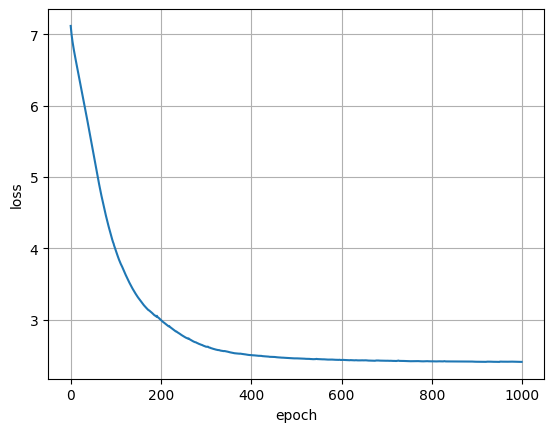

In [27]:
print(f'min loss: {min(losses)}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);

max metric: -1.7554278373718262


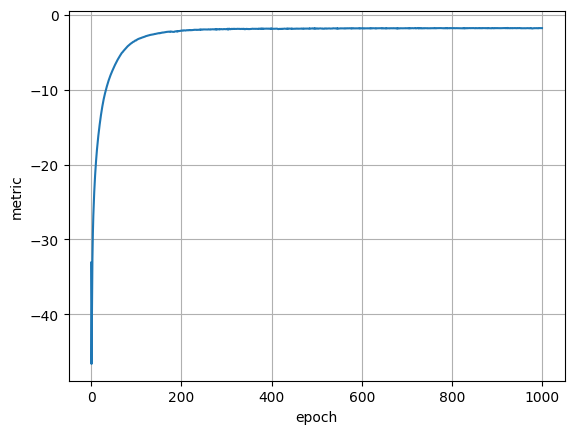

In [26]:
print(f'max metric: {max(metrics)}')

plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

In [20]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

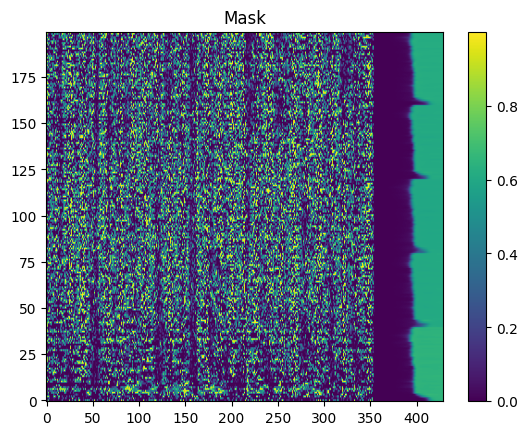

In [21]:
plot_mask(mask.detach()[0][0])

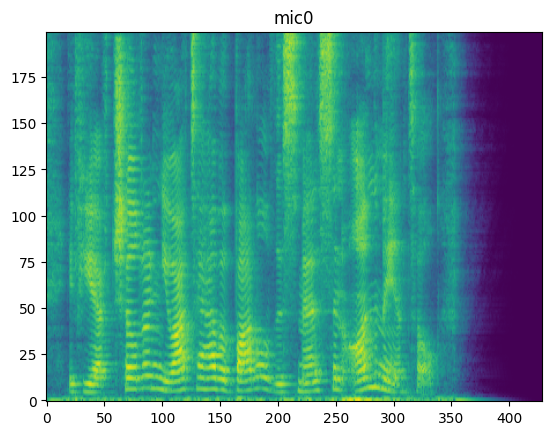

In [23]:
plt.title('mic0')
plt.imshow(torch.log(mag+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

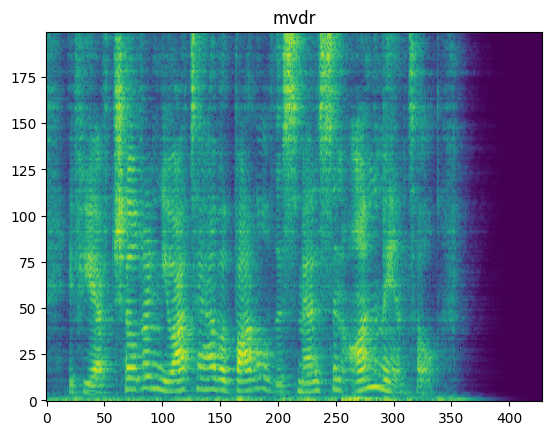

In [24]:
plt.title('mvdr')
plt.imshow(torch.log(mvdr(spec_sample, mask[0]).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

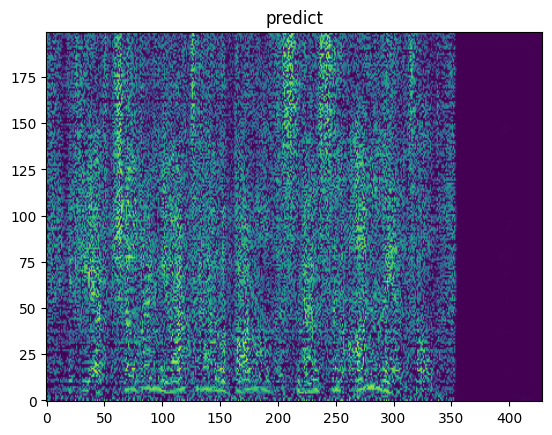

In [22]:
plt.title('predict')
plt.imshow(torch.log(mag_predict+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto");

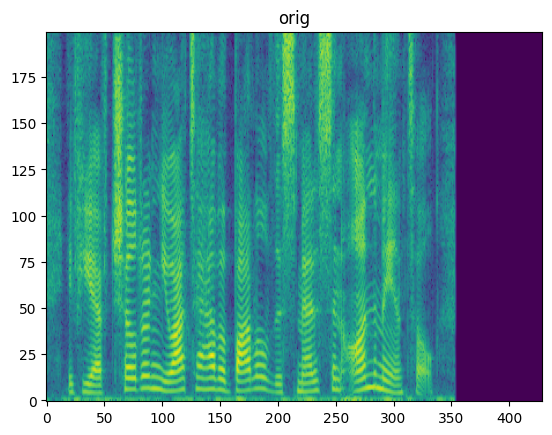

In [25]:
plt.title('orig')
plt.imshow(torch.log(stft.stft(train_target).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");